In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#    Define your Dataset    
sADF=pd.read_csv(r"Site A - Tue Feb 15 2022 to Thu Jun 30 2022.csv")
sBDF=pd.read_csv(r"Site B - Tue Feb 15 2022 to Thu Jun 30 2022.csv")

In [3]:
# ++++++++++++++++++ This part has contains all the necessary functions  +++++++++++++

# The following function identifies all the rains events and 
#  wellflood duration and drawdown durations, levels & rates within each event
def IdentifyEvents(df,dry_hours_skip,moving_hours):
    #  This method use moving STD (std_mov) (last (moving_hours) hours) for start and end of an event
    # For the start of an event use: std_mov > *8 (changeable) percent of range of std_mov 
    # To detect the end of an event use: std_mov < 3 (changeable) percentage of range of std_mov
    
    skip=int(dry_hours_skip*(60/5))    # (dry_hours_skip) hours of no significant change in water level means start of another event
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    
    # +++++++++++ this part calculates the moving STD  ++++++++++
    
    std_mov=moving_std(df,moving_hours)      # calculates STD of last (moving_hours) hours
    
    # ???????????? This part set the threshold for START and END of an event  ??????????????
    
    rng3p=np.max(std_mov)*(3/100)            # 3 percent of the range of moving STD
    rng8p=np.max(std_mov)*(7.5/100)          # 7.5 percent of the range of moving STD
    
    
    
    # ++++++++++++++++ This part identify the rainfall events  ++++++++++++++++
    
    nre=True     #indicator if the current time falls under "No Rain Event" or not
    # rpc=0
    #dpc=0
    start_time=[]
    end_time=[]
    start_index=[]
    end_index=[]
    #duration=[]
    i=1
    while i<df.shape[0]-1:
        if std_mov[i]>=rng8p:
            if nre==True:
                # This is a new rainfall event
                start_time.append(df["Timestamp"][df.index.to_list()[0]+i])
                start_index.append(df.index.to_list()[0]+i)
                nre=False
                i+=1
            while std_mov[i]>rng3p:
                i+=1
            if np.max(std_mov[i+1:i+skip+1])<rng8p:
                # dry period starts from index i+1
                end_time.append(df["Timestamp"][df.index.to_list()[0]+i])
                end_index.append(df.index.to_list()[0]+i)
                nre=True
                i=i+skip
        i+=1
    
    # ++++++++++++++ This part finds wellflood duration and drawdown rates +++++++++++++
    
    wf_d=[]      # Wellflood duration for an event
    max_wl=[]    # Max water level
    dd_d=[]      # drawdown durations
    dd_l=[]      # drawdown levels
    dd_r=[]      # drawdown rates
    dd_r_ave=[]  # average drawdown rate within an event
    for event in range(np.size(start_index)):
        wfd,e_dd,e_dl,e_dr,start,end=drawdown_wellflood_event(df,wl_mm,event,start_index,end_index)
        wf_d.append(wfd)
        max_wl.append(np.max(wl_mm[start_index[event]:end_index[event]+1]))    # max water level for each event
        dd_r_ave.append(np.average(e_dr))
        dd_d=np.append(dd_d,e_dd)
        dd_l=np.append(dd_l,e_dl)
        dd_r=np.append(dd_r,e_dr)
        #print(np.size(dd_r))  
    return start_time,end_time,start_index,end_index,np.subtract(end_index,start_index),max_wl,wf_d,dd_r_ave,dd_r,wl_mm,rng8p,rng3p

# following function identifies wellflood duration and drawdown durations, levels & rates within an event
def drawdown_wellflood_event(df,wlevel_mm,index,start_index,end_index):
    #index=i
    max_mov=moving_max(df[start_index[index]:end_index[index]],0.5)
    #std_mov=moving_std(df[start_indexA[index]:end_indexA[index]],0.5)
    wl=wlevel_mm[start_index[index]:end_index[index]+1]
    
    # ++++++  Wellflood Duration within an event  ++++++
    
    # ???????????   Well flood happens when water level is above 5% of min waterlevel within an event
    c=0
    for j in wl:
        if j>=np.min(wl)+(np.max(wl)-np.min(wl))*0.05:     
            c+=1
    wfd=c*(5/60)     #measured in hours
    
    # ++++++++++  finding peak and bottom from an event (there could be multiple drawdowns) ++++++++
    
    start=[]
    end=[]
    i=1
    while i <np.size(wl)-1:
        if max_mov[i]-wl[i]>0:
            start.append(i-1)
            while max_mov[i]-wl[i]>0:
                i+=1
                if i>=np.size(wl):
                    break
            end.append(i-1)
        i+=1
    # Discards peaks that's have very small amount of drawdown
    i=0
    while i<np.size(start)-1:
        if abs(wl[start[i]]-wl[end[i]])<150:
            if wl[start[i]]<wl[start[i+1]]:
                start.pop(i)
                end.pop(i)
            else:
                start.pop(i+1)
                end.pop(i)
            continue
        else:
            i+=1
    i=0
    while i<np.size(start)-1:  
        if abs(wl[end[i]]-wl[start[i+1]])<150:
            end.pop(i)
            start.pop(i+1)
            continue
        else:
            i+=1
    # Discard peaks which are very close to each other
    i=0
    while i<np.size(start)-1:
        if (start[i+1]-start[i])<25:
            if wl[start[i+1]]>wl[start[i]]:
                start.pop(i)
                end.pop(i)
            else:
                start.pop(i+1)
                end.pop(i)
            continue
        else:
            i+=1
            
    # +++++++++++ calculates all the drawdown durations, levels and rates within an event +++++++++++
    
    e_dd=[]    # drawdown durations
    e_dl=[]    # drawdown levels
    e_dr=[]    # drawdown rates
    for j in range(np.size(start)):
            dd=((end[j]-start[j])*5)/60        # Measured in hours
            dl=wl[start[j]]-wl[end[j]]    #measured in mm
            dr=dl/dd                      #Measured in mm/hour
            e_dd.append(dd)
            e_dl.append(dl)
            e_dr.append(dr)
    return wfd,e_dd,e_dl,e_dr,start,end

# Calculate moving STD of last *few hours
def moving_std(df,period_in_hour):      
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    mov_std=[0]
    mean_mov=[wl_mm[0]]
    for i in range(np.size(wl_mm)):
        periods=int(period_in_hour*(60/5))    
        if i<periods:
            mov_std.append(np.std(wl_mm[:i+1]))
            mean_mov.append(np.mean(wl_mm[:i+1]))
        else:
            mov_std.append(np.std(wl_mm[i-periods:i+1]))
            mean_mov.append(np.mean(wl_mm[i-periods:i+1]))
    return mov_std

# Calculate moving MAX of last *few hours
def moving_max(df,period_in_hour):
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    mov_max=[wl_mm[0]]
    for i in range(np.size(wl_mm)):
        periods=int(period_in_hour*(60/5))    
        if i<periods:
            mov_max.append(np.max(wl_mm[:i+1]))
        else:
            mov_max.append(np.max(wl_mm[i-periods:i+1]))
    return mov_max


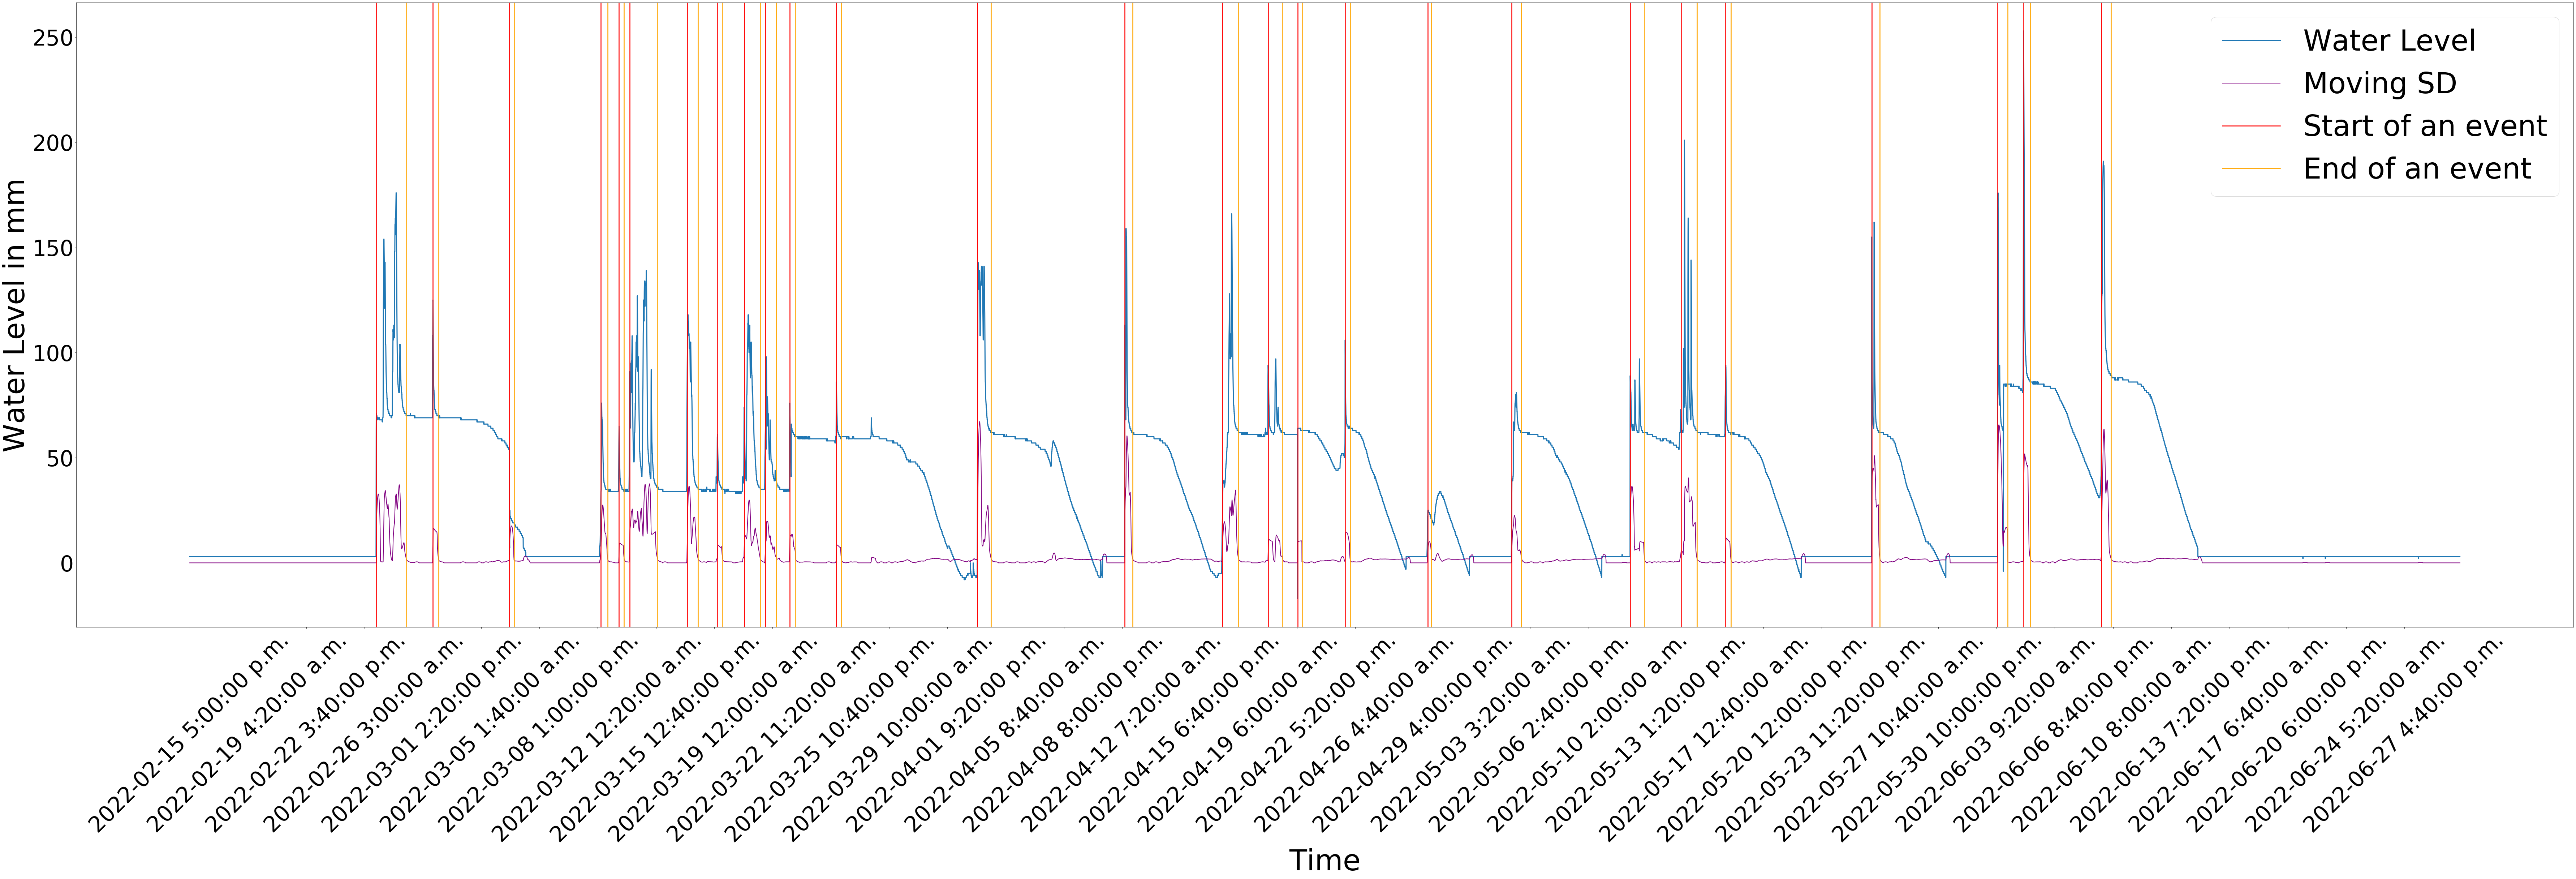

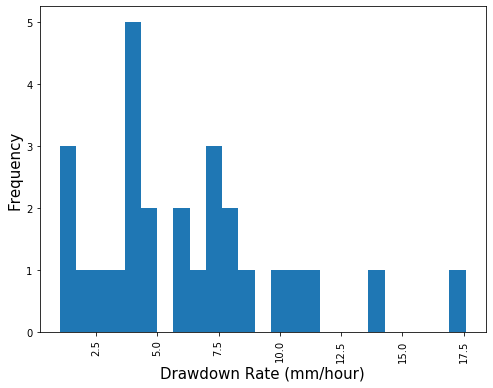

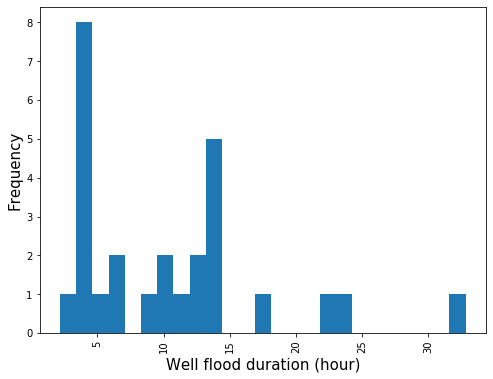

Rainfall_start_time         Rainfall_end_time  Rainfall_start_index  \
0    2022-02-26 7:45:00 p.m.   2022-02-28 2:35:00 p.m.                  3201   
1    2022-03-02 4:25:00 a.m.  2022-03-02 12:40:00 p.m.                  4169   
2    2022-03-06 6:20:00 p.m.  2022-03-07 12:40:00 a.m.                  5488   
3    2022-03-12 4:40:00 a.m.   2022-03-12 2:35:00 p.m.                  7052   
4    2022-03-13 7:50:00 a.m.   2022-03-13 3:05:00 p.m.                  7366   
5   2022-03-13 10:55:00 p.m.   2022-03-15 2:50:00 p.m.                  7547   
6    2022-03-17 9:05:00 a.m.  2022-03-18 12:45:00 a.m.                  8533   
7    2022-03-19 4:30:00 a.m.  2022-03-19 11:55:00 a.m.                  9054   
8    2022-03-20 6:40:00 p.m.   2022-03-21 5:50:00 p.m.                  9512   
9    2022-03-22 1:00:00 a.m.   2022-03-22 5:00:00 p.m.                  9876   
10  2022-03-23 11:45:00 a.m.   2022-03-23 8:10:00 p.m.                 10293   
11   2022-03-26 6:40:00 a.m.   2022-03-26 1:40:00 p.m.                 11096   
12   2022-04-03 4:20:00 p.m.  2022-04-04 11:50:00 a.m.                 13516   
13  2022-04-12 11:05:00 a.m.  2022-04-12 10:15:00 p.m.                 16045   
14   2022-04-18 6:30:00 a.m.   2022-04-19 5:35:00 a.m.                 17718   
15  2022-04-20 11:55:00 p.m.   2022-04-21 8:40:00 p.m.                 18503   
16   2022-04-22 6:10:00 p.m.  2022-04-23 12:15:00 a.m.                 19010   
17   2022-04-25 2:05:00 p.m.   2022-04-25 9:05:00 p.m.                 19825   
18  2022-04-30 12:15:00 p.m.   2022-04-30 5:40:00 p.m.                 21243   
19  2022-05-05 12:20:00 p.m.   2022-05-06 2:10:00 a.m.                 22684   
20   2022-05-12 1:35:00 p.m.  2022-05-13 10:05:00 a.m.                 24715   
21   2022-05-15 2:15:00 p.m.   2022-05-16 1:10:00 p.m.                 25587   
22   2022-05-18 5:50:00 a.m.   2022-05-18 1:30:00 p.m.                 26350   
23  2022-05-26 10:55:00 p.m.  2022-05-27 10:45:00 a.m.                 28859   
24  2022-06-03 11:05:00 a.m.   2022-06-04 1:35:00 a.m.                 31021   
25  2022-06-04 11:50:00 p.m.   2022-06-05 9:45:00 a.m.                 31462   
26   2022-06-09 3:20:00 p.m.   2022-06-10 5:05:00 a.m.                 32800   

    Rainfall_end_index  Rainfall_duration (periods)  Max WaterLevel(mm)  \
0                 3715                          514               176.0   
1                 4268                           99               125.0   
2                 5564                           76                25.0   
3                 7171                          119                76.0   
4                 7453                           87                65.0   
5                 8026                          479               139.0   
6                 8721                          188               118.0   
7                 9143                           89                61.0   
8                 9790                          278               118.0   
9                10068                          192                98.0   
10               10394                          101                76.0   
11               11180                           84                85.0   
12               13750                          234               143.0   
13               16179                          134               159.0   
14               17995                          277               166.0   
15               18752                          249                97.0   
16               19083                           73                64.0   
17               19909                           84               106.0   
18               21308                           65                25.0   
19               22850                          166                81.0   
20               24961                          246                97.0   
21               25862                          275               201.0   
22               26442                     

In [42]:
#  ------------------- This is a result generation section -----------------------------

#  ++++++++++++++++++++++  Enter the Name of Your Dataset Below +++++++++++++++++++++++++
dataset=sBDF

#  +++++++++++++   Choose the value of your parameters
dry_hours_to_skip=6        # in hours
moving_hours_forSTD=6      # in hours



pd.to_datetime(dataset["Timestamp"]);

# This part calculate all rainfall events
start_time,end_time,start_index,end_index,rf_duration,max_wl,wflood_d,drawdownR_ave,drawdown_rates,water_level,startp,endp=IdentifyEvents(dataset,dry_hours_to_skip,moving_hours_forSTD)
rf_event=pd.DataFrame({"Rainfall_start_time":start_time,"Rainfall_end_time":end_time,"Rainfall_start_index":start_index,"Rainfall_end_index":end_index,"Rainfall_duration (periods)":rf_duration,"Max WaterLevel(mm)":max_wl,"WellFlood_duration (hours)":wflood_d,"Avg. Drawdown Rate(mm/hour)":drawdownR_ave})



# This draw all data set with events being identified
fig=plt.figure(figsize=(120, 30))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,np.size(water_level),1000)])
ax.set_xticklabels([dataset["Timestamp"][i] for i in range(0,np.size(water_level),1000)])

wle,=plt.plot(water_level,label='Water Level',linewidth=3)
#plt.plot(mean_mov)
std_mov=moving_std(dataset,moving_hours_forSTD)
mstd,=plt.plot(std_mov,label="Moving SD",linewidth=2,color="purple")
for i in start_index:
    st=plt.axvline(x=i, linewidth=2.5,color='r',label="Start of an event")
for i in end_index:
    en=plt.axvline(x=i,linewidth=2.5, color='orange',label="End of an event")
# plt.axhline(y=endp, color='orange', linestyle='-')
# plt.axhline(y=startp, color='red', linestyle='-')
plt.xlabel('Time',fontsize=80)
plt.ylabel('Water Level in mm',fontsize=80)
plt.tick_params(axis='x',labelsize=60,rotation=45)
plt.tick_params(axis='y',labelsize=60)
plt.legend(loc = 'best',handles=[wle,mstd,st,en],fontsize=80)
#plt.title("Rainfall Event Detection",fontsize=50)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(drawdown_rates,bins=25)
plt.xlabel('Drawdown Rate (mm/hour)',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.tick_params(axis='x',labelsize=10,rotation=90)
plt.tick_params(axis='y',labelsize=10)
#plt.title("Histogram for Drawdown Rate",fontsize=10)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(wflood_d,bins=25)
plt.xlabel("Well flood duration (hour)",fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.tick_params(axis='x',labelsize=10,rotation=90)
plt.tick_params(axis='y',labelsize=10)
#plt.title("Histogram for Well Flood duration",fontsize=10)
plt.show()


rf_event

In [21]:
# Under Construction
# In the subsequent parts we can look into a particular event  

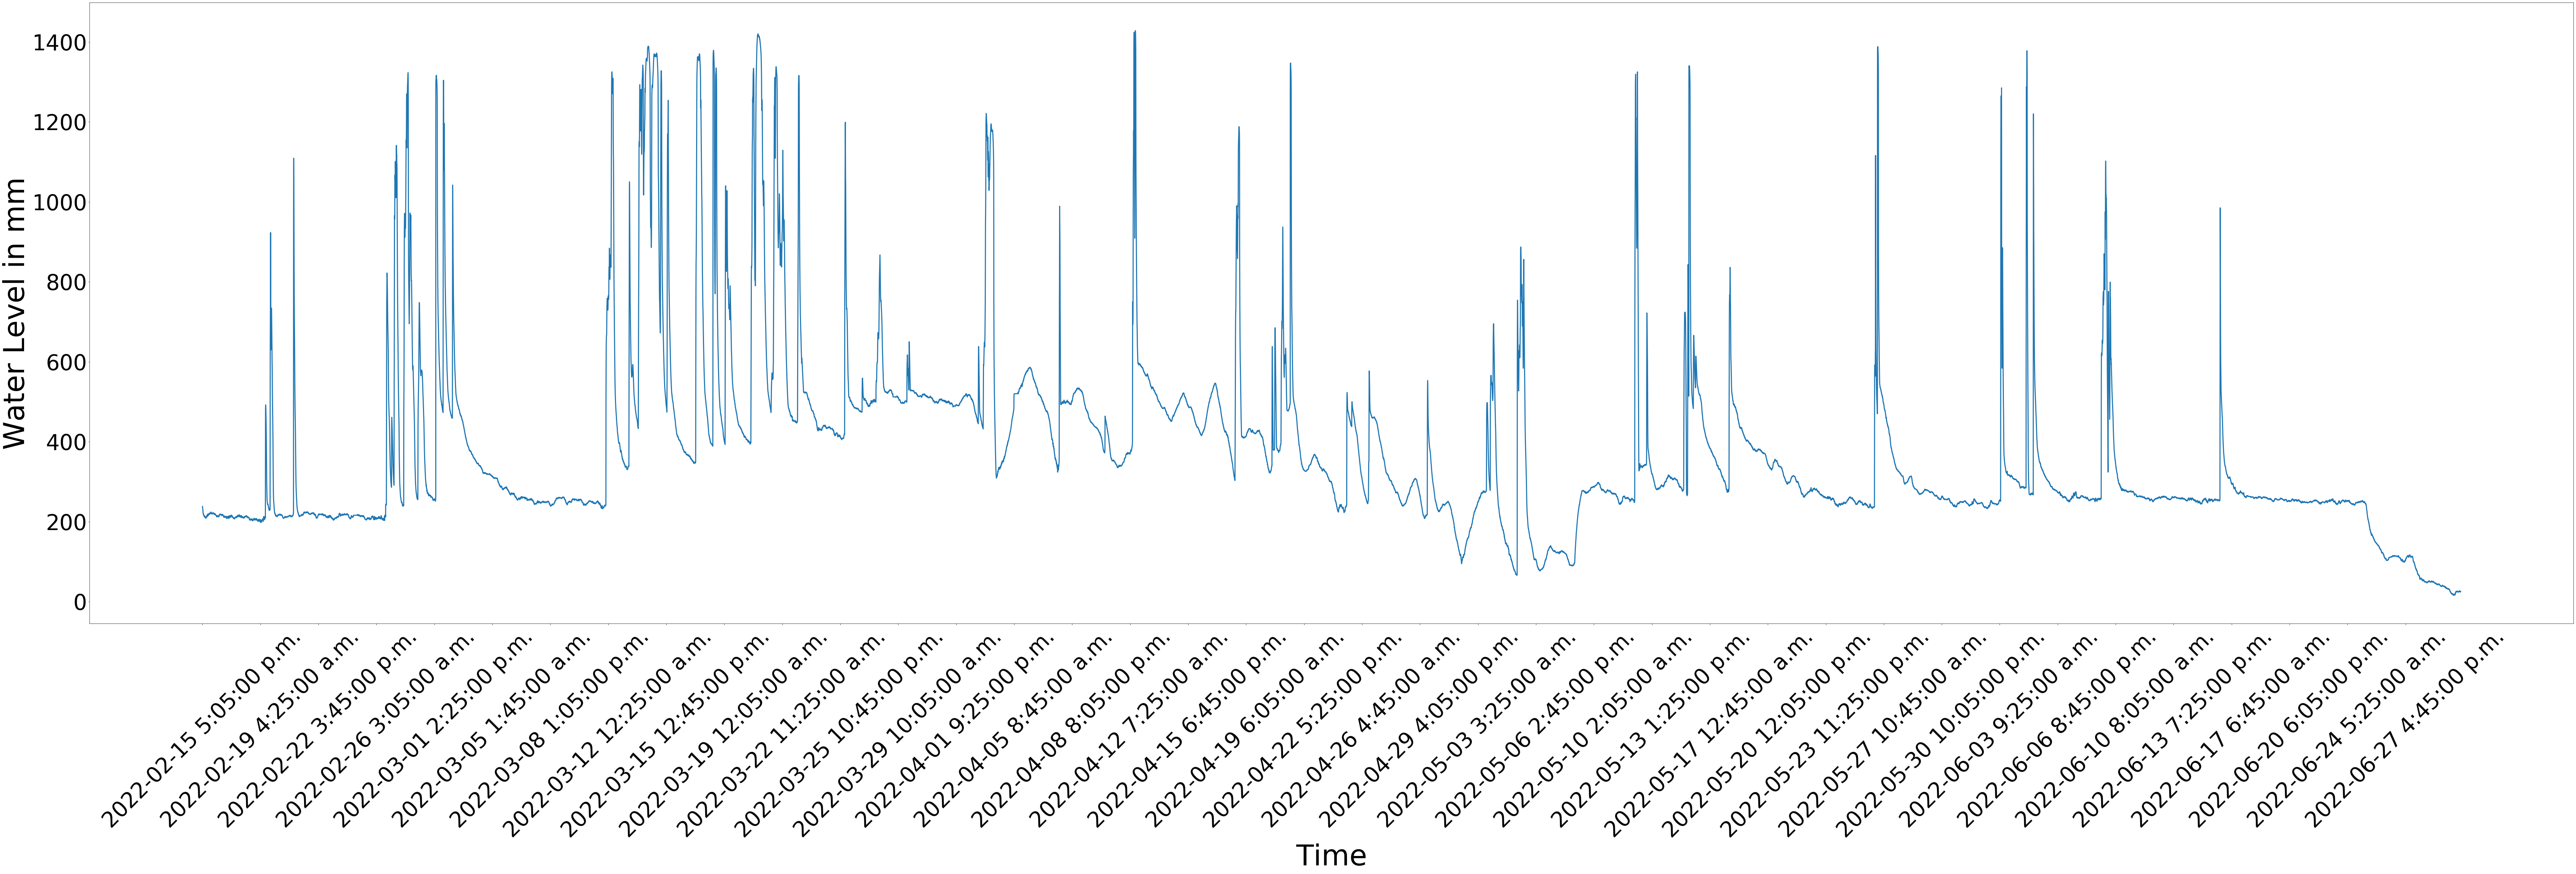

In [33]:
fig=plt.figure(figsize=(120, 30))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,np.size(water_level),1000)])
ax.set_xticklabels([dataset["Timestamp"][i] for i in range(0,np.size(water_level),1000)])

plt.plot(water_level,label='Water Level',linewidth=3)
plt.xlabel('Time',fontsize=80)
plt.ylabel('Water Level in mm',fontsize=80)
plt.tick_params(axis='x',labelsize=60,rotation=45)
plt.tick_params(axis='y',labelsize=60)
#plt.legend(loc = 'best',handles=[wle,mstd,st,en],fontsize=30)
#plt.title("Water Level vs Time [Site B] "+dataset["Timestamp"][0]+"  to  "+dataset["Timestamp"][dataset.shape[0]-1],fontsize=80)
plt.show()

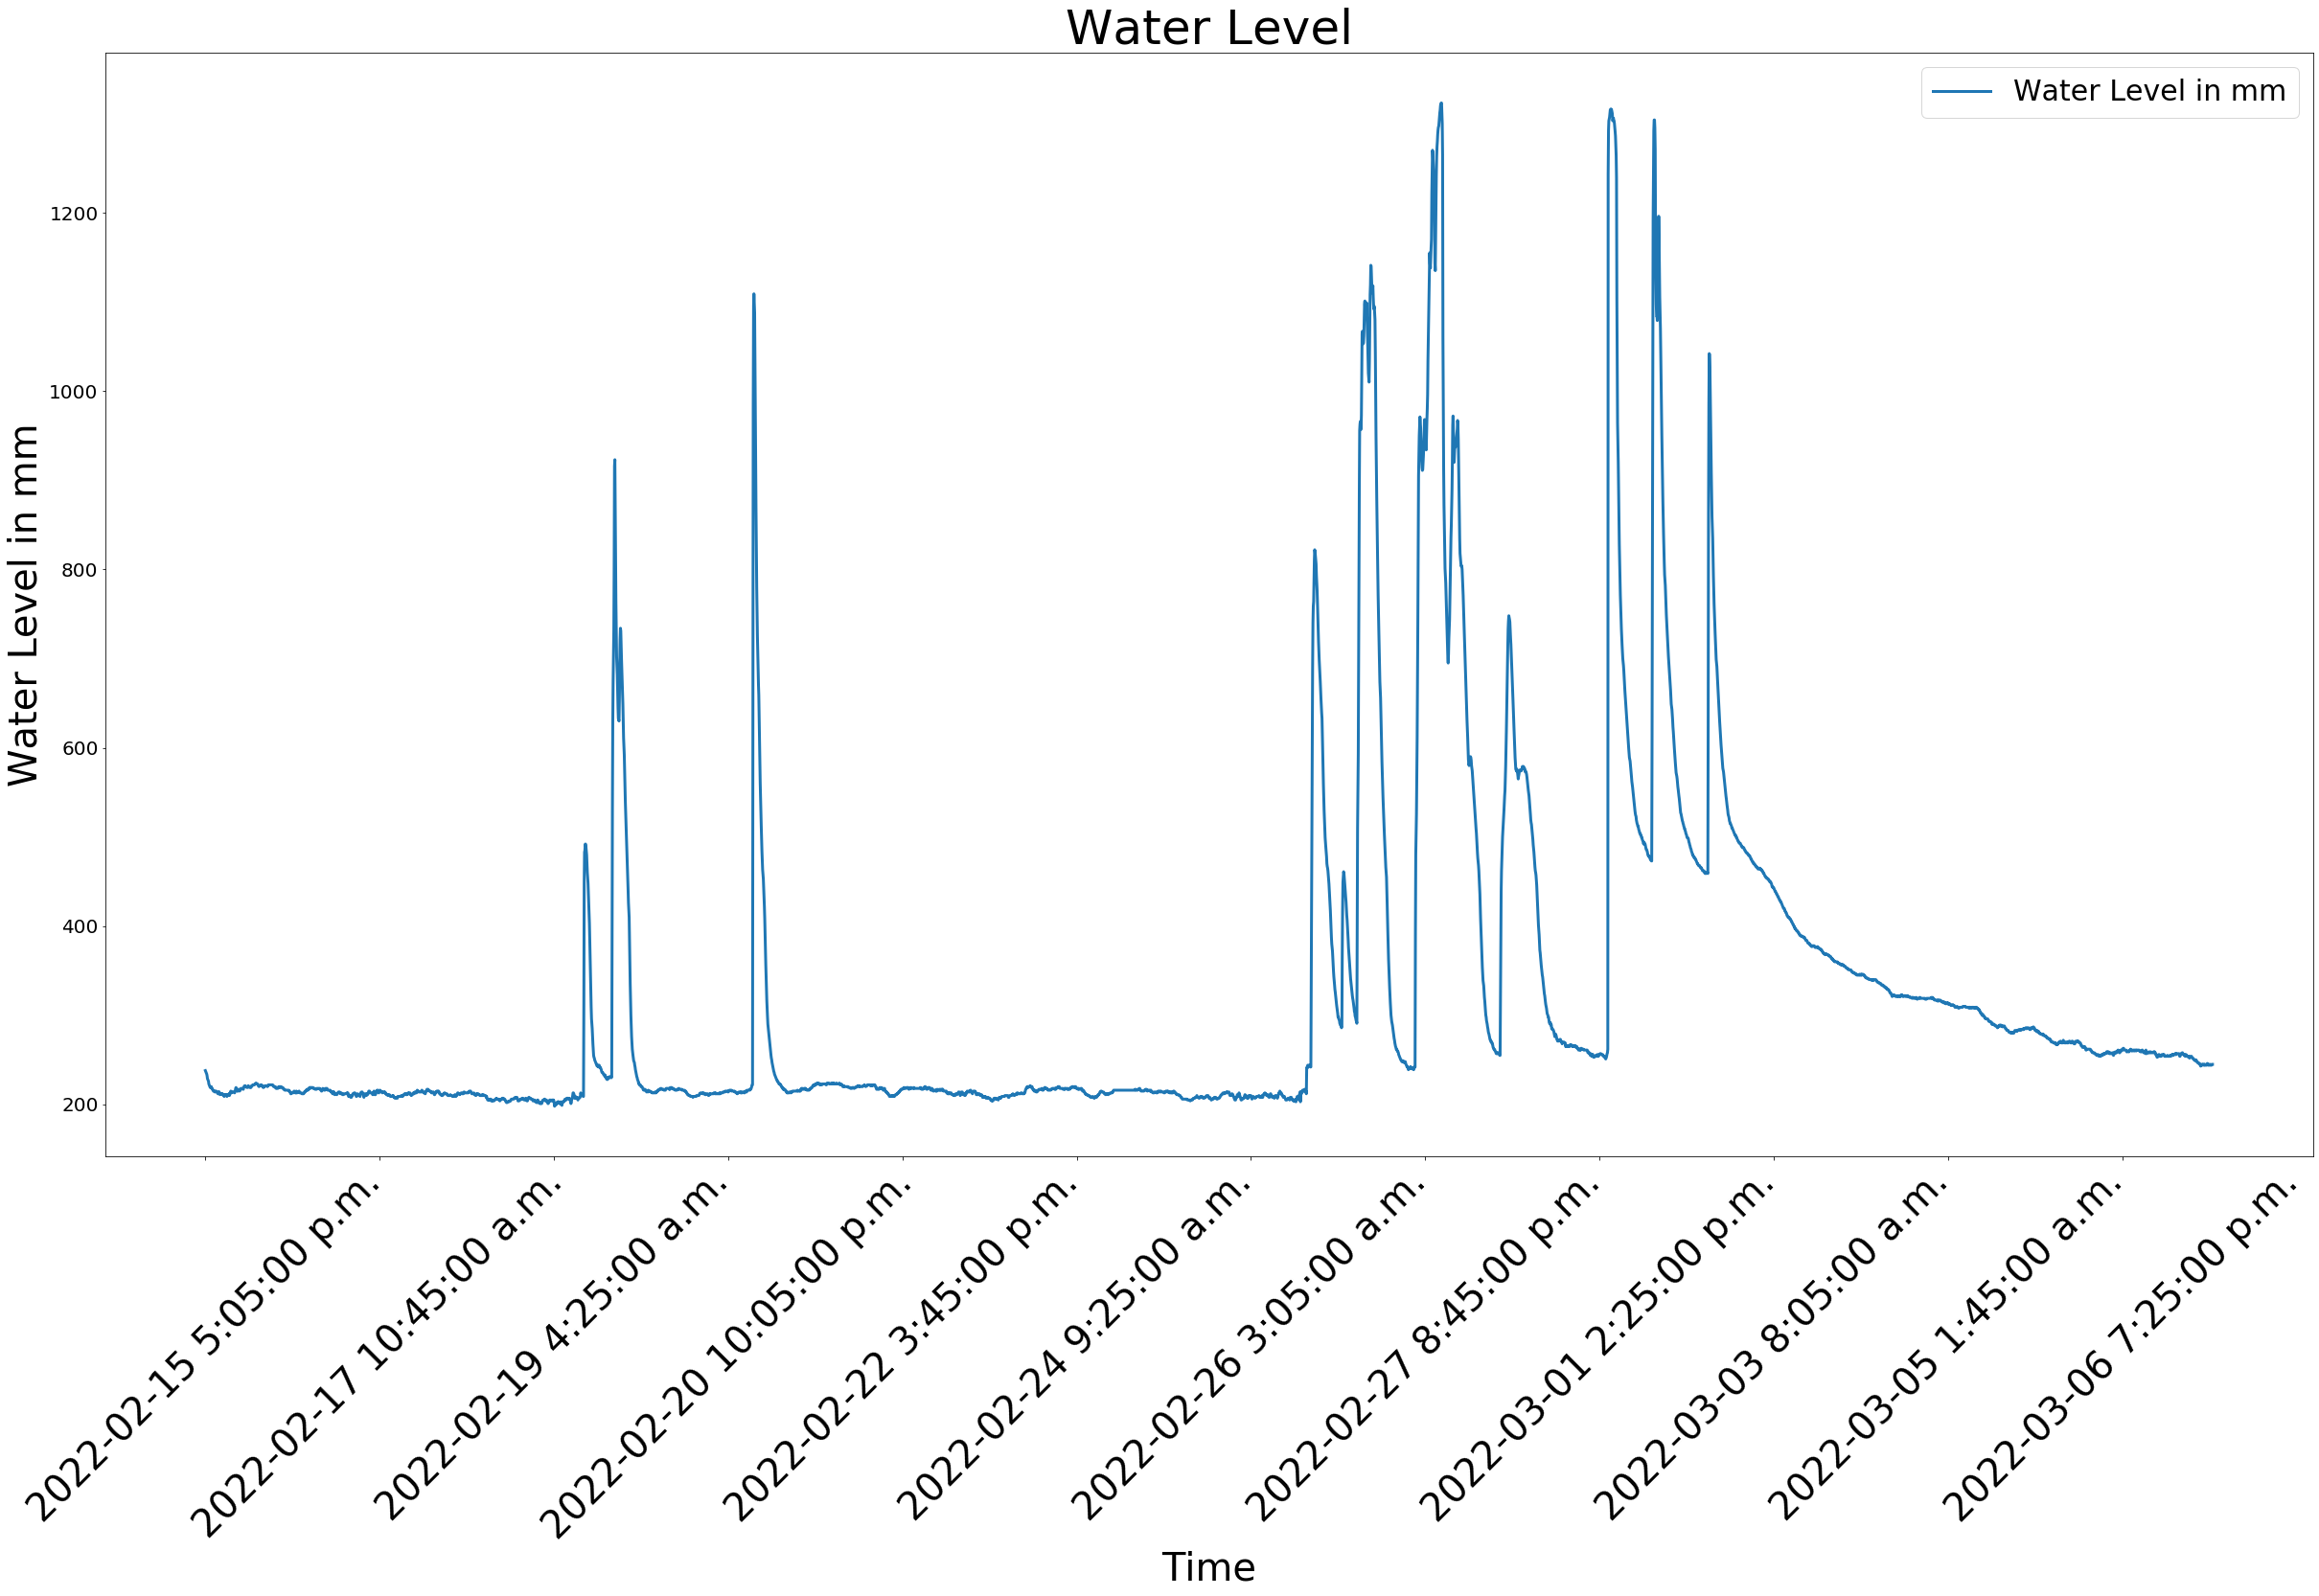

In [24]:
fig=plt.figure(figsize=(40, 20))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,np.size(water_level[:5760]),500)])
ax.set_xticklabels([dataset["Timestamp"][i] for i in range(0,np.size(water_levelA[:5760]),500)])

plt.plot(water_level[:5760],linewidth=3,label="Water Level in mm")
plt.xlabel('Time',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=40,rotation=45)
plt.tick_params(axis='y',labelsize=20)
plt.legend(loc = 'best',fontsize=30)
#plt.title("Water Level between "+sADF["Timestamp"][0]+"   to    "+sADF["Timestamp"][sADF.shape[0]-1],fontsize=50)
plt.title("Water Level",fontsize=50)
plt.show()

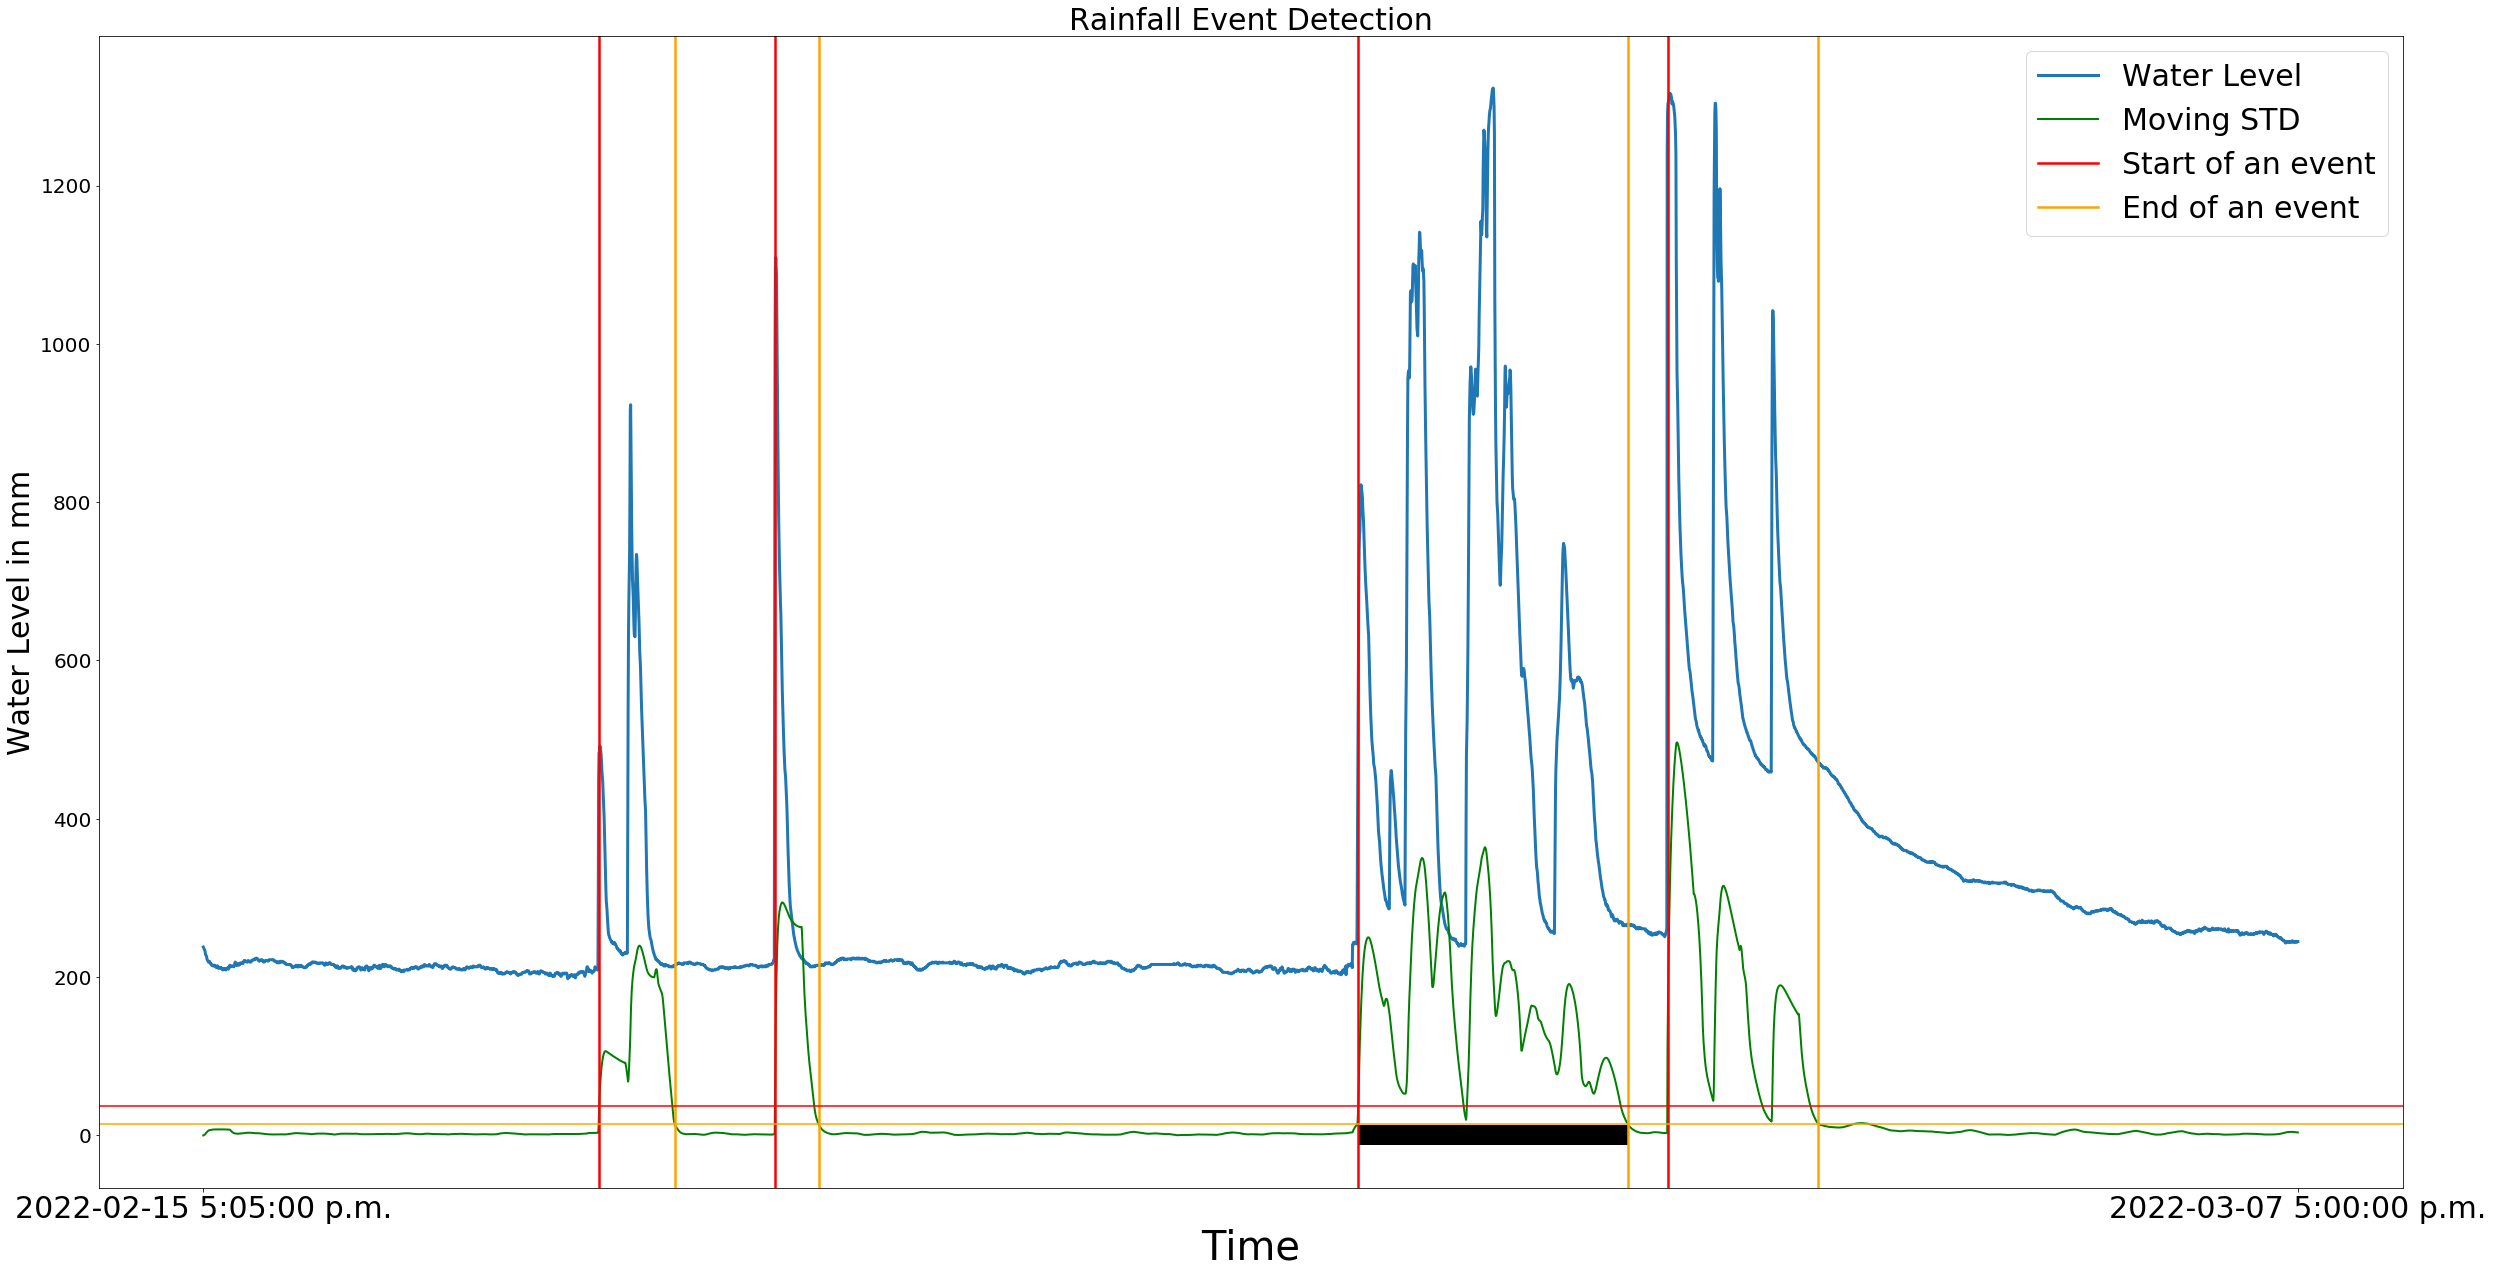

In [25]:
# This draw (Partial) data set with events being identified
fig=plt.figure(figsize=(40, 20))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,np.size(water_level[:5760]),5759)])
ax.set_xticklabels([dataset["Timestamp"][i] for i in range(0,np.size(water_level[:5760]),5759)])

wle,=plt.plot(water_level[:5760],label='Water Level',linewidth=3)
#plt.plot(mean_mov)
std_mov=moving_std(dataset,moving_hours_forSTD)
mstd,=plt.plot(std_mov[:5760],label="Moving STD",linewidth=2,color="green")
for i in start_index[:4]:
    st=plt.axvline(x=i, linewidth=2.5,color='r',label="Start of an event")
for i in end_index[:4]:
    en=plt.axvline(x=i,linewidth=2.5, color='orange',label="End of an event")
plt.axhline(y=endp, color='orange', linestyle='-')
plt.axhline(y=startp, color='red', linestyle='-')
plt.hlines(y=0,xmin=3176,xmax=3916, color='black', linewidth=20,linestyle='-')
plt.xlabel('Time',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=30)
plt.tick_params(axis='x',labelsize=30,rotation=0)
plt.tick_params(axis='y',labelsize=20)
plt.legend(loc = 'best',handles=[wle,mstd,st,en],fontsize=30)
#plt.title("Water Level between "+sADF["Timestamp"][0]+"   to    "+sADF["Timestamp"][5760],fontsize=30)
plt.title("Rainfall Event Detection",fontsize=30)
plt.show()

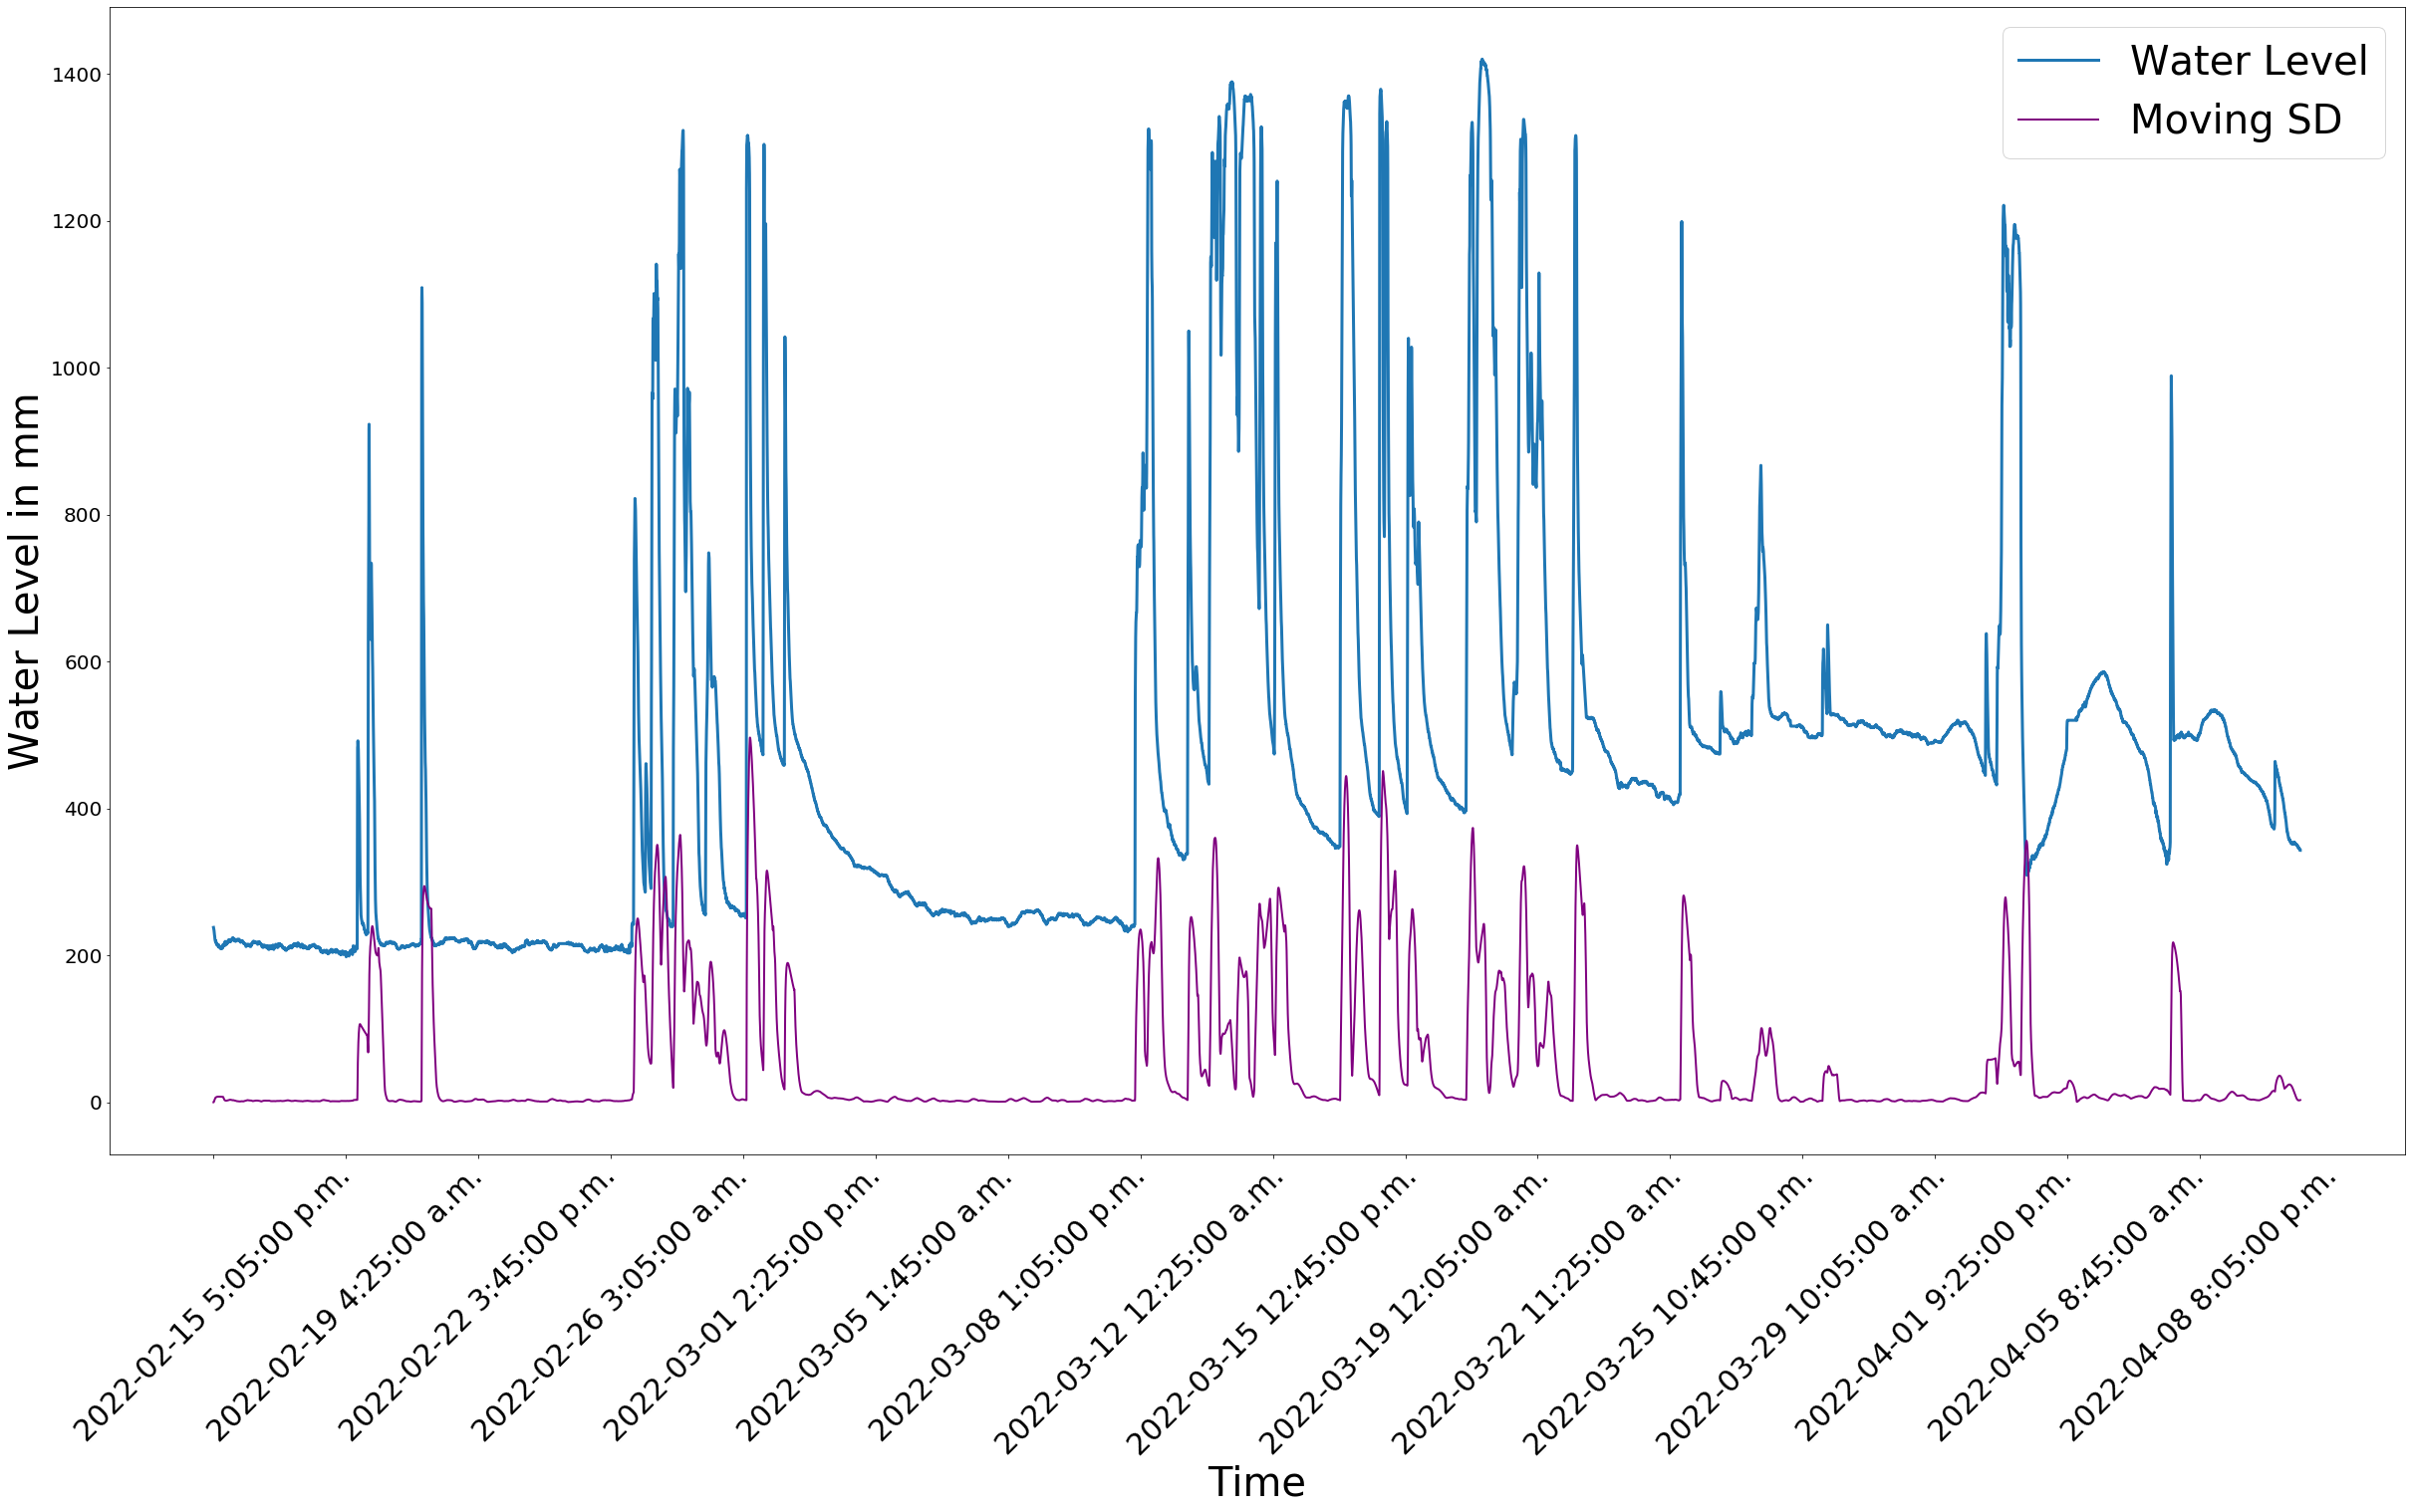

In [34]:
# This draw (Partial) data set with Moving SD
fig=plt.figure(figsize=(40, 20))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,np.size(water_level[:15760]),1000)])
ax.set_xticklabels([dataset["Timestamp"][i] for i in range(0,np.size(water_level[:15760]),1000)])

wle,=plt.plot(water_level[:15760],label='Water Level',linewidth=3)
#plt.plot(mean_mov)
std_mov=moving_std(dataset,moving_hours_forSTD)
mstd,=plt.plot(std_mov[:15760],label="Moving SD",linewidth=2,color="purple")
plt.xlabel('Time',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=45)
plt.tick_params(axis='y',labelsize=20)
plt.legend(loc = 'best',handles=[wle,mstd],fontsize=40)
#plt.title("Water Level between "+sADF["Timestamp"][0]+"   to    "+sADF["Timestamp"][5760],fontsize=30)
#plt.title("Water Level with moving SD",fontsize=30)
plt.show()

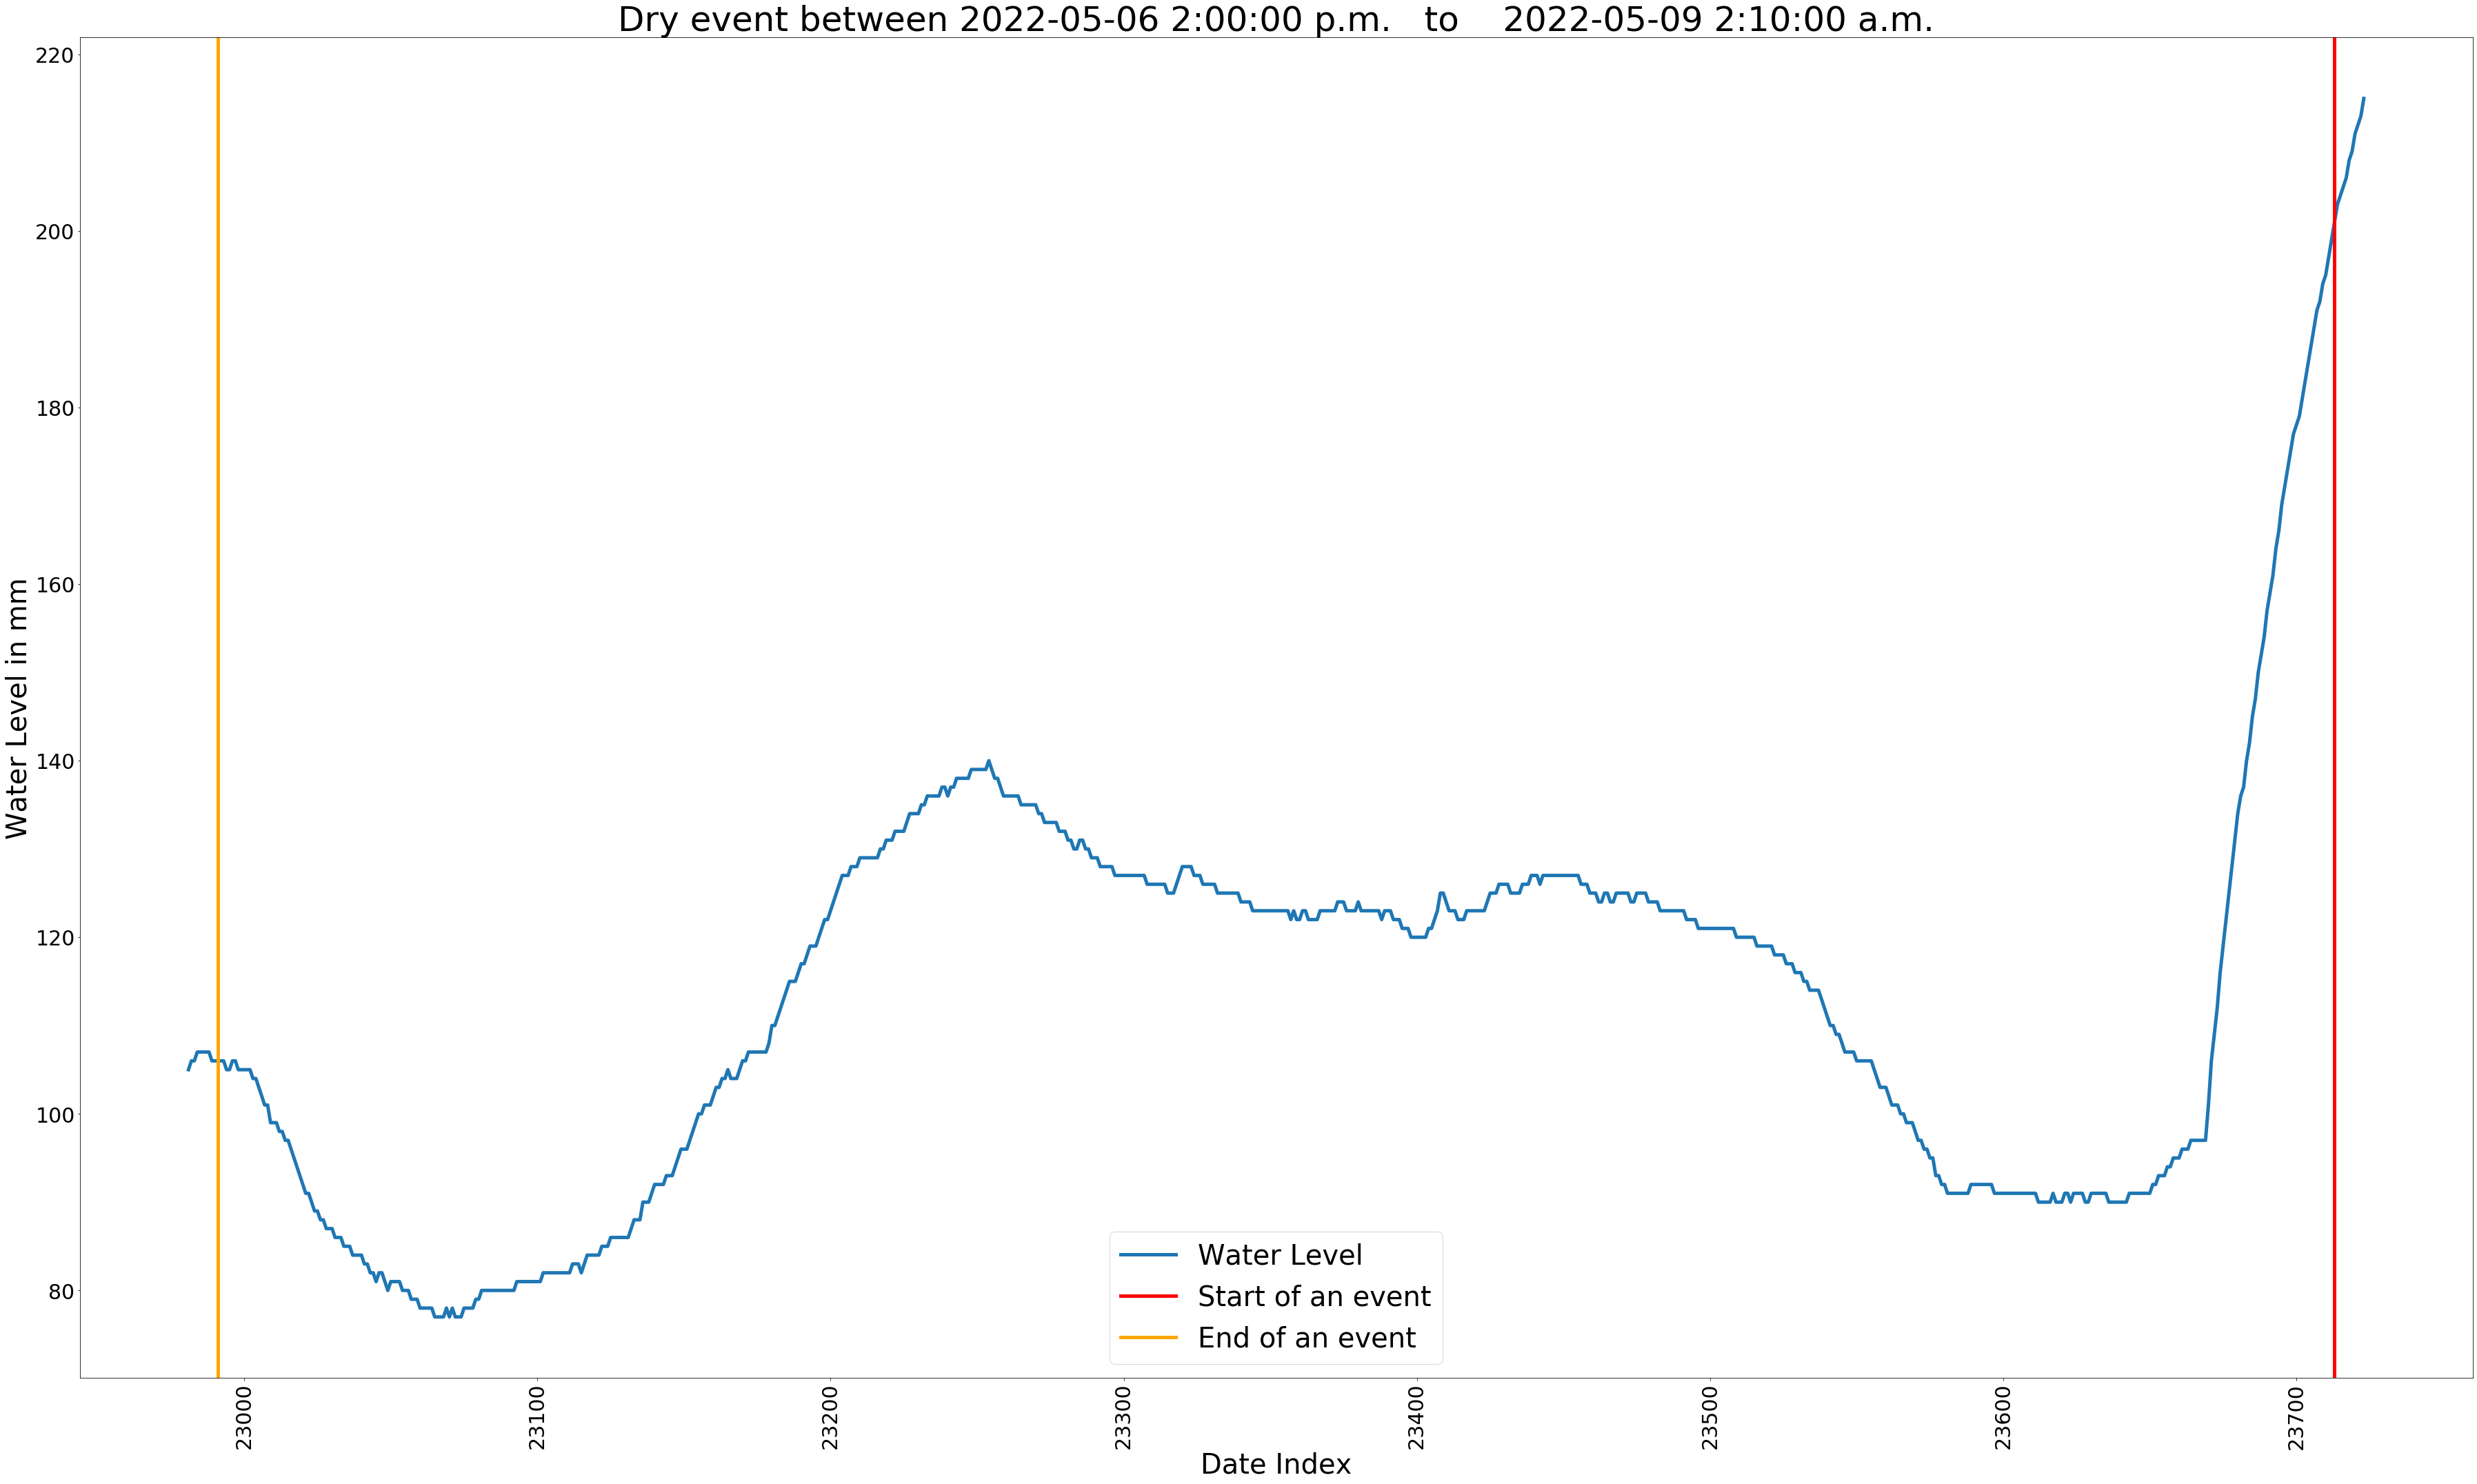

In [6]:
# Let's look at a particular No !Rainfall event
buffer=10
index=22
X=range(end_index[index-1]-buffer,start_index[index]+buffer+1)
Y=water_level[rf_event["Rainfall_end_index"][index-1]-buffer:rf_event["Rainfall_start_index"][index]+buffer+1]
plt.figure(figsize=(50, 30))
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axvline(x=start_index[index], linewidth=5,color='r',label="Start of an event")
plt.axvline(x=end_index[index-1],linewidth=5, color='orange',label="End of an event")
plt.title('No Rainfall Event')
plt.xlabel('Date Index',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=40)
plt.title("Dry event between "+end_time[index-1]+"   to    "+start_time[index],fontsize=50)
plt.tight_layout()
plt.show()

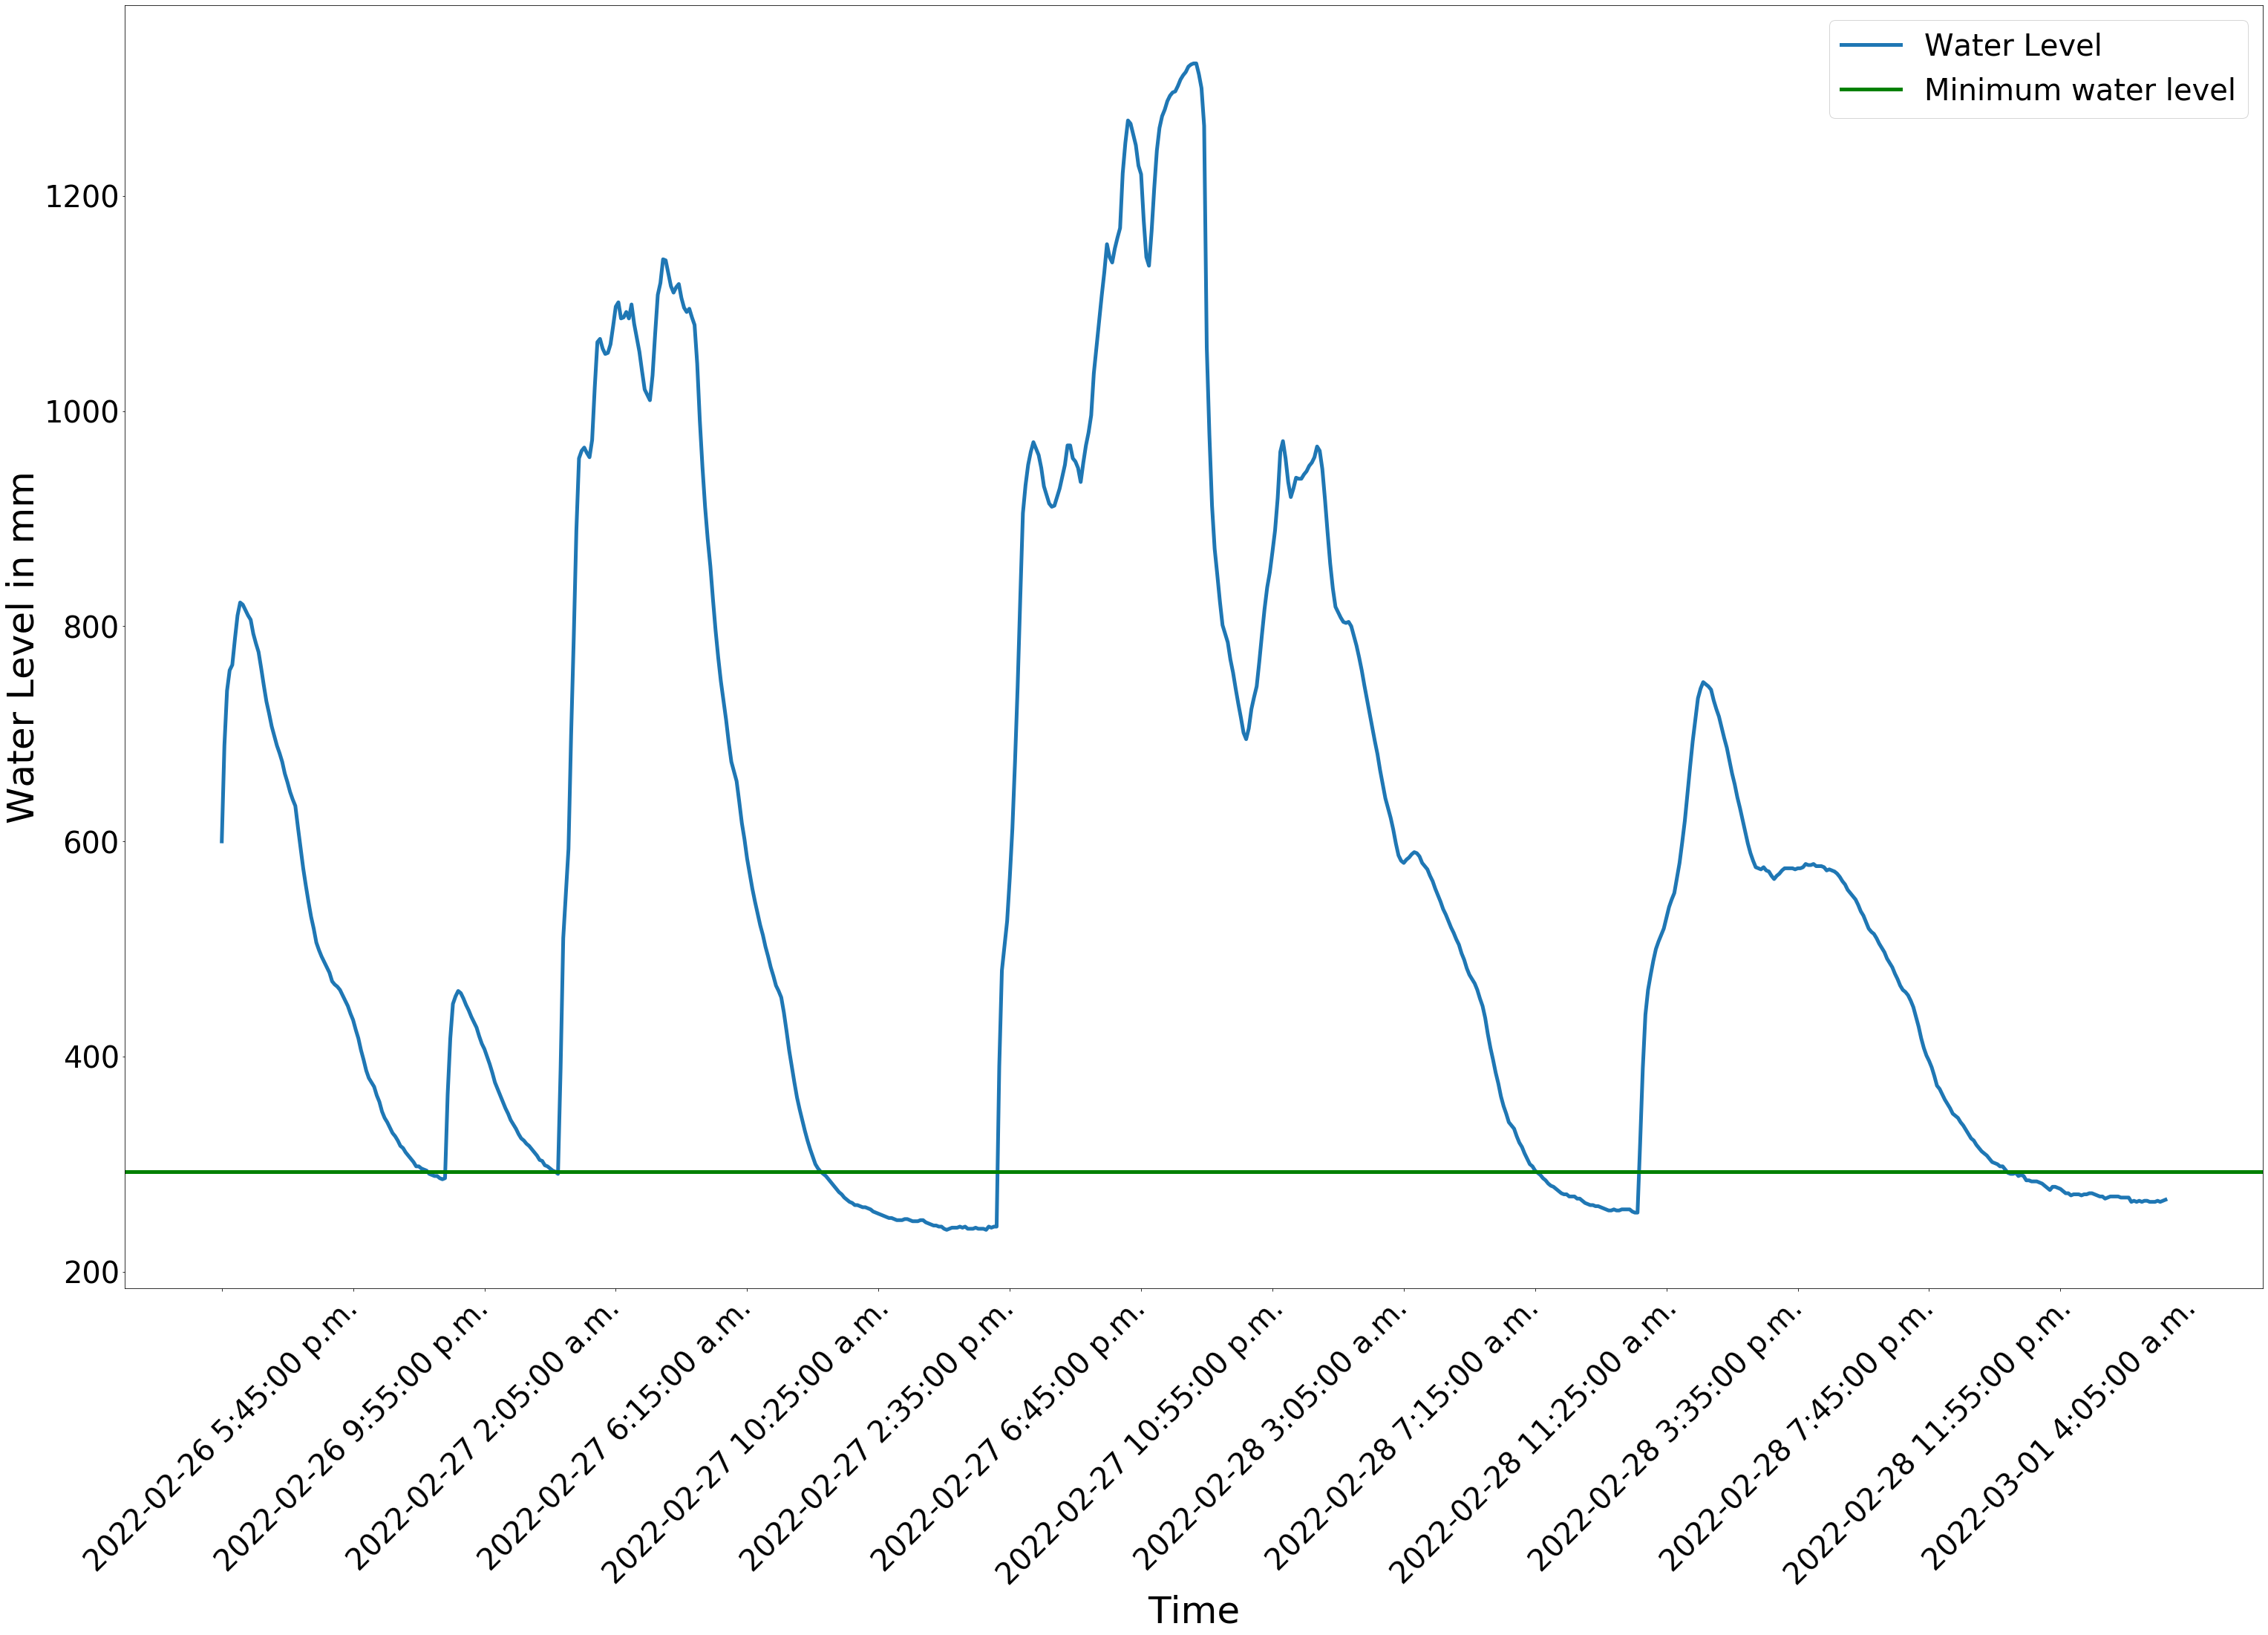

564


In [38]:
# Let's see a particular !Rainfall event
buffer=0
index=2
#X=Timestamp[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer+1]
X=range(start_index[index]-buffer,end_index[index]+buffer+1)
Y=water_level[start_index[index]-buffer:end_index[index]+buffer+1]
fig=plt.figure(figsize=(50, 30))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(start_index[index],end_index[index],50)])
ax.set_xticklabels([dataset["Timestamp"][i] for i in range(start_index[index],end_index[index],50)])
plt.plot(X,Y,linewidth=5,label="Water Level")
#plt.axvline(x=start_index[index],linewidth=5,color='r',label="Start of an event")
#plt.axvline(x=end_index[index],linewidth=5, color='orange',label="End of an event")
plt.axhline(y=np.min(Y)+(np.max(Y)-np.min(Y))*0.05,color="green",label="Minimum water level",linewidth=5)
#plt.title('Rainfall Event')
plt.xlabel('Time',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=40,rotation=45)
plt.tick_params(axis='y',labelsize=40)
plt.legend(loc = 'best',fontsize=40)

#plt.tight_layout()
#plt.title("Single Rainfall Event",fontsize=50)
plt.show()

c=0
for i in range(start_index[index],end_index[index]+1):
    if water_level[i]>=np.min(Y)+(np.max(Y)-np.min(Y))*0.05:
        c+=1
print(c)
        

741


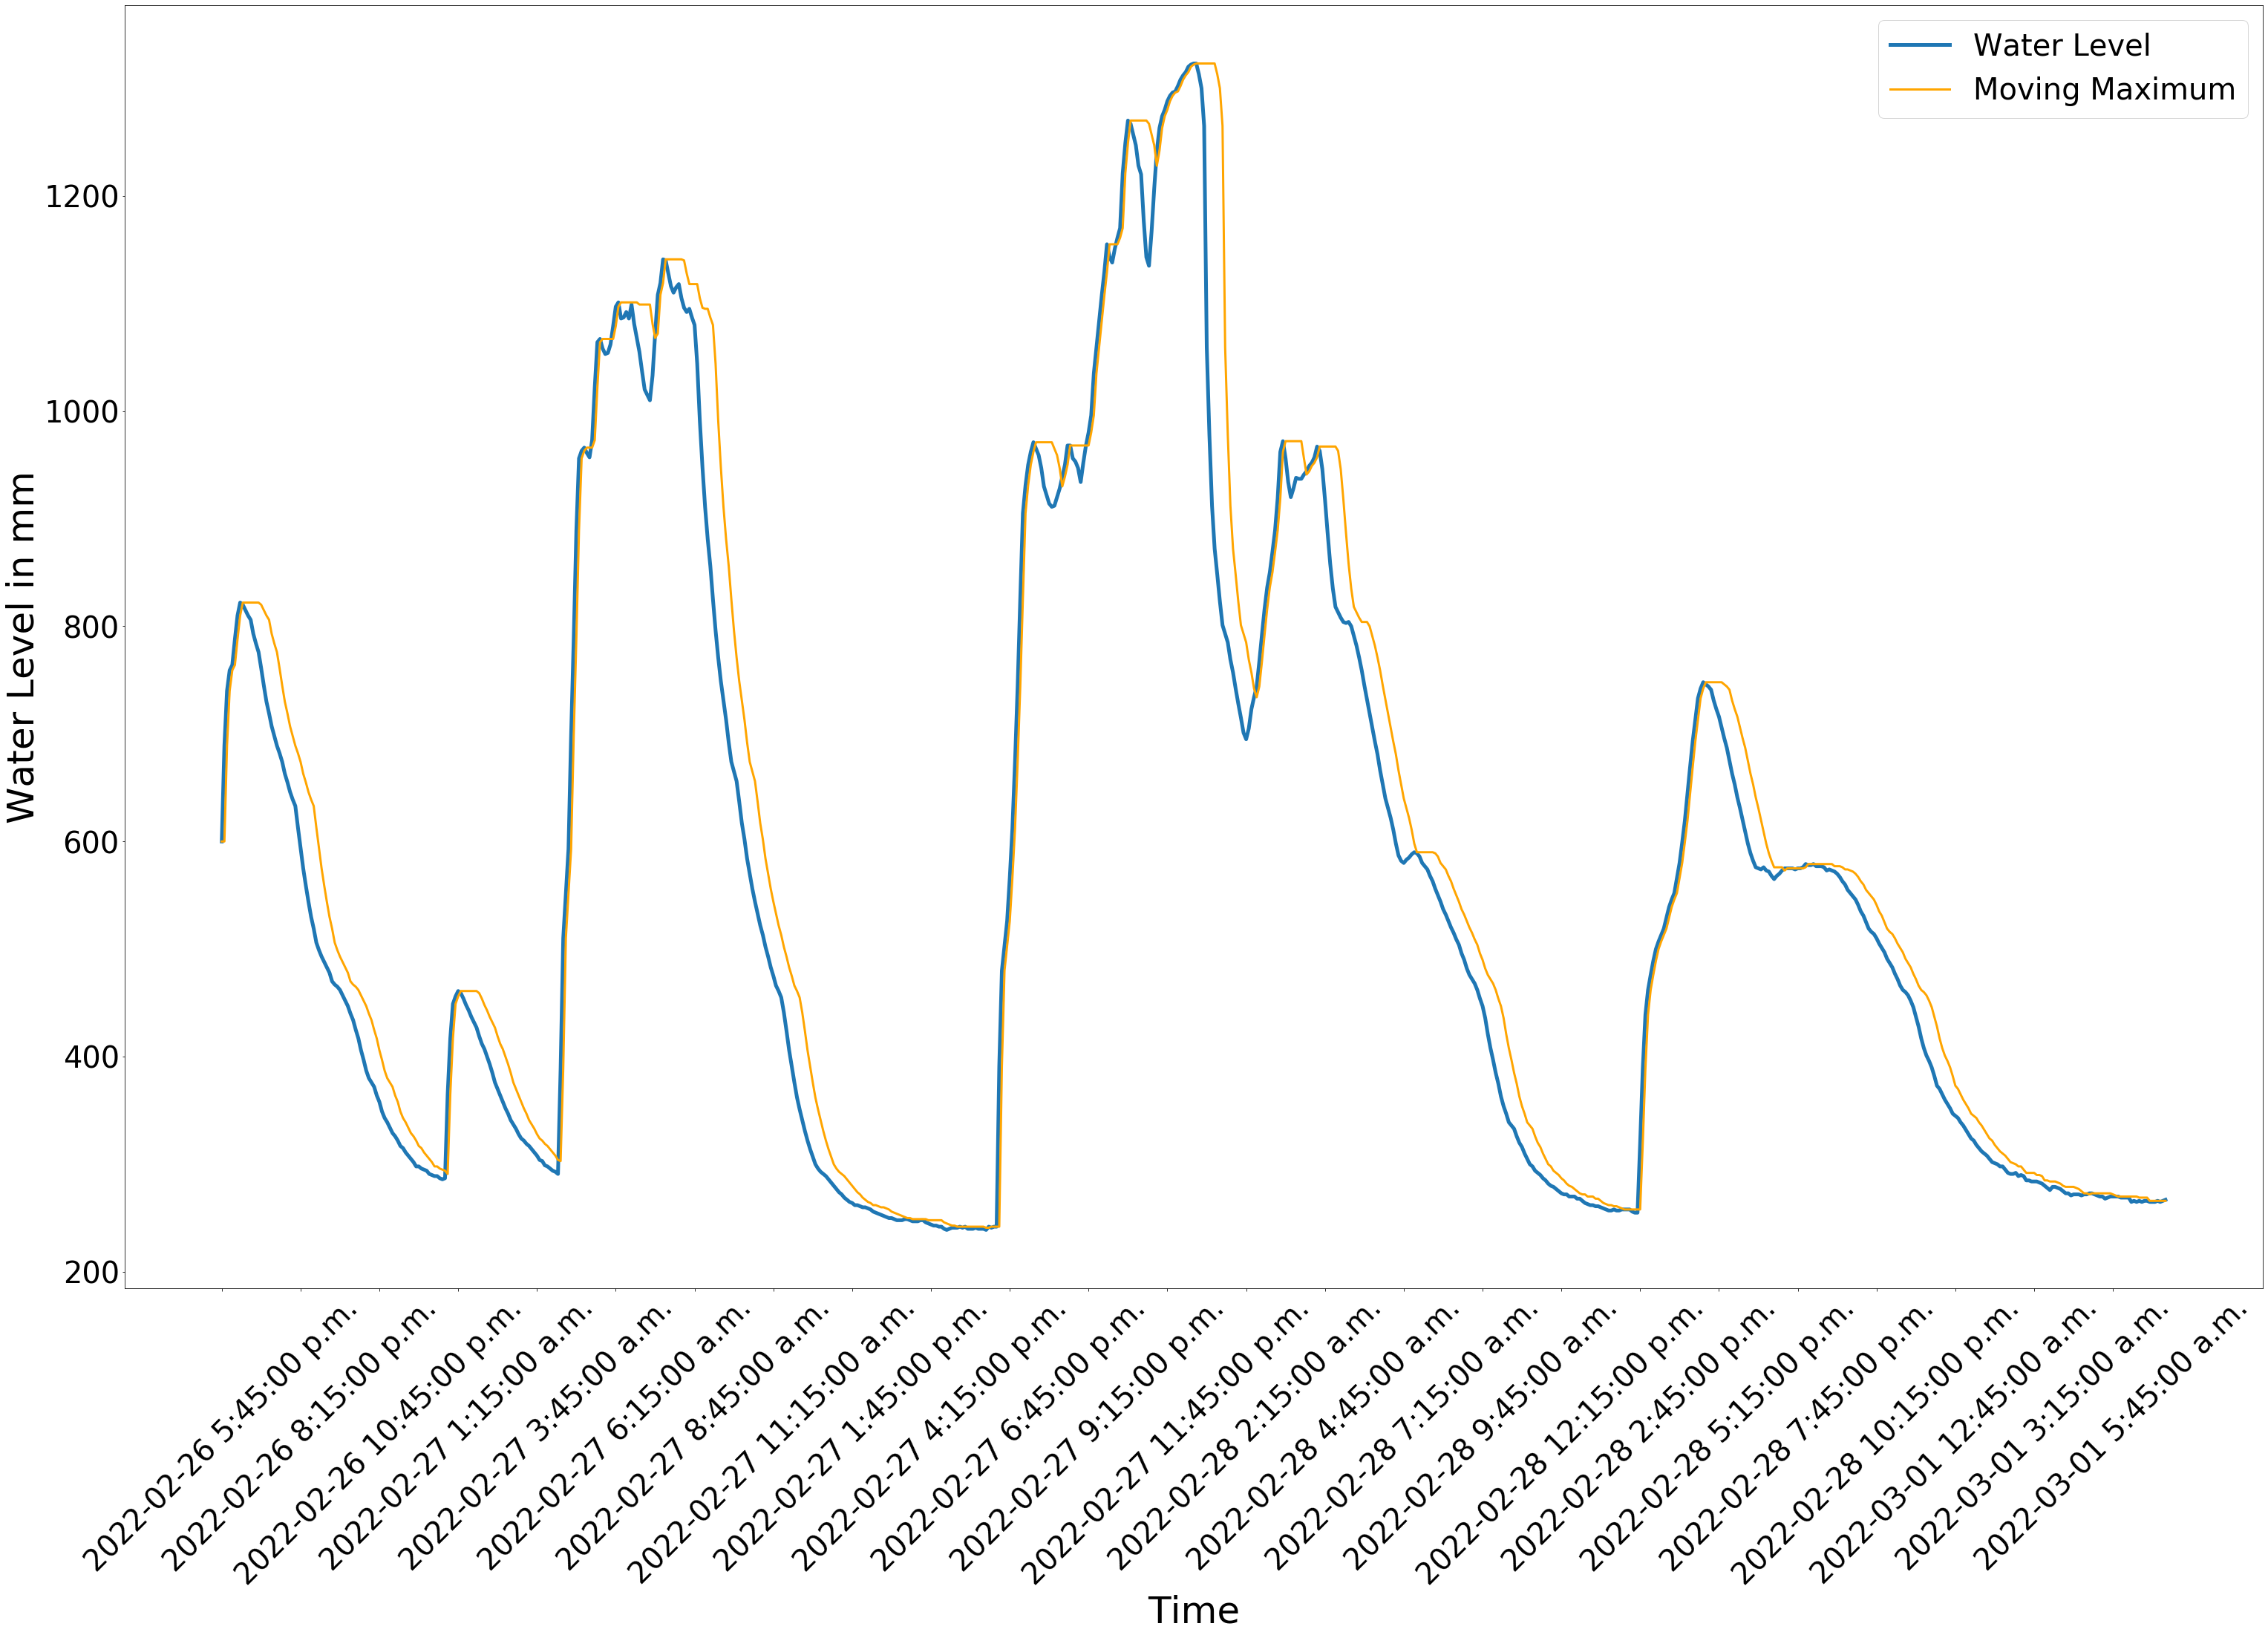

In [39]:
# This part draws a particular event with moving MAX
buffer=0
index=2
max_mov=moving_max(dataset[start_index[index]-buffer:end_index[index]+buffer],0.5)
std_mov=moving_std(dataset[start_index[index]-buffer:end_index[index]+buffer],0.5)
wl=water_level[start_index[index]-buffer:end_index[index]+buffer+1]
print(np.size(wl))
fig=plt.figure(figsize=(50, 30))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,rf_duration[index],30)])
ax.set_xticklabels([dataset["Timestamp"][i] for i in range(start_index[index],end_index[index],30)])
plt.plot(wl,linewidth=5,label="Water Level")
#plt.axhline(y=np.min(wl)+(np.max(wl)-np.min(wl))*.01)
plt.xlabel('Time',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=40,rotation=45)
plt.tick_params(axis='y',labelsize=40)
plt.plot(max_mov,linewidth=3,color="orange",label="Moving Maximum")
#plt.title("Peak and Base-level Detection",fontsize=50)
plt.legend(loc = 'best',fontsize=40)

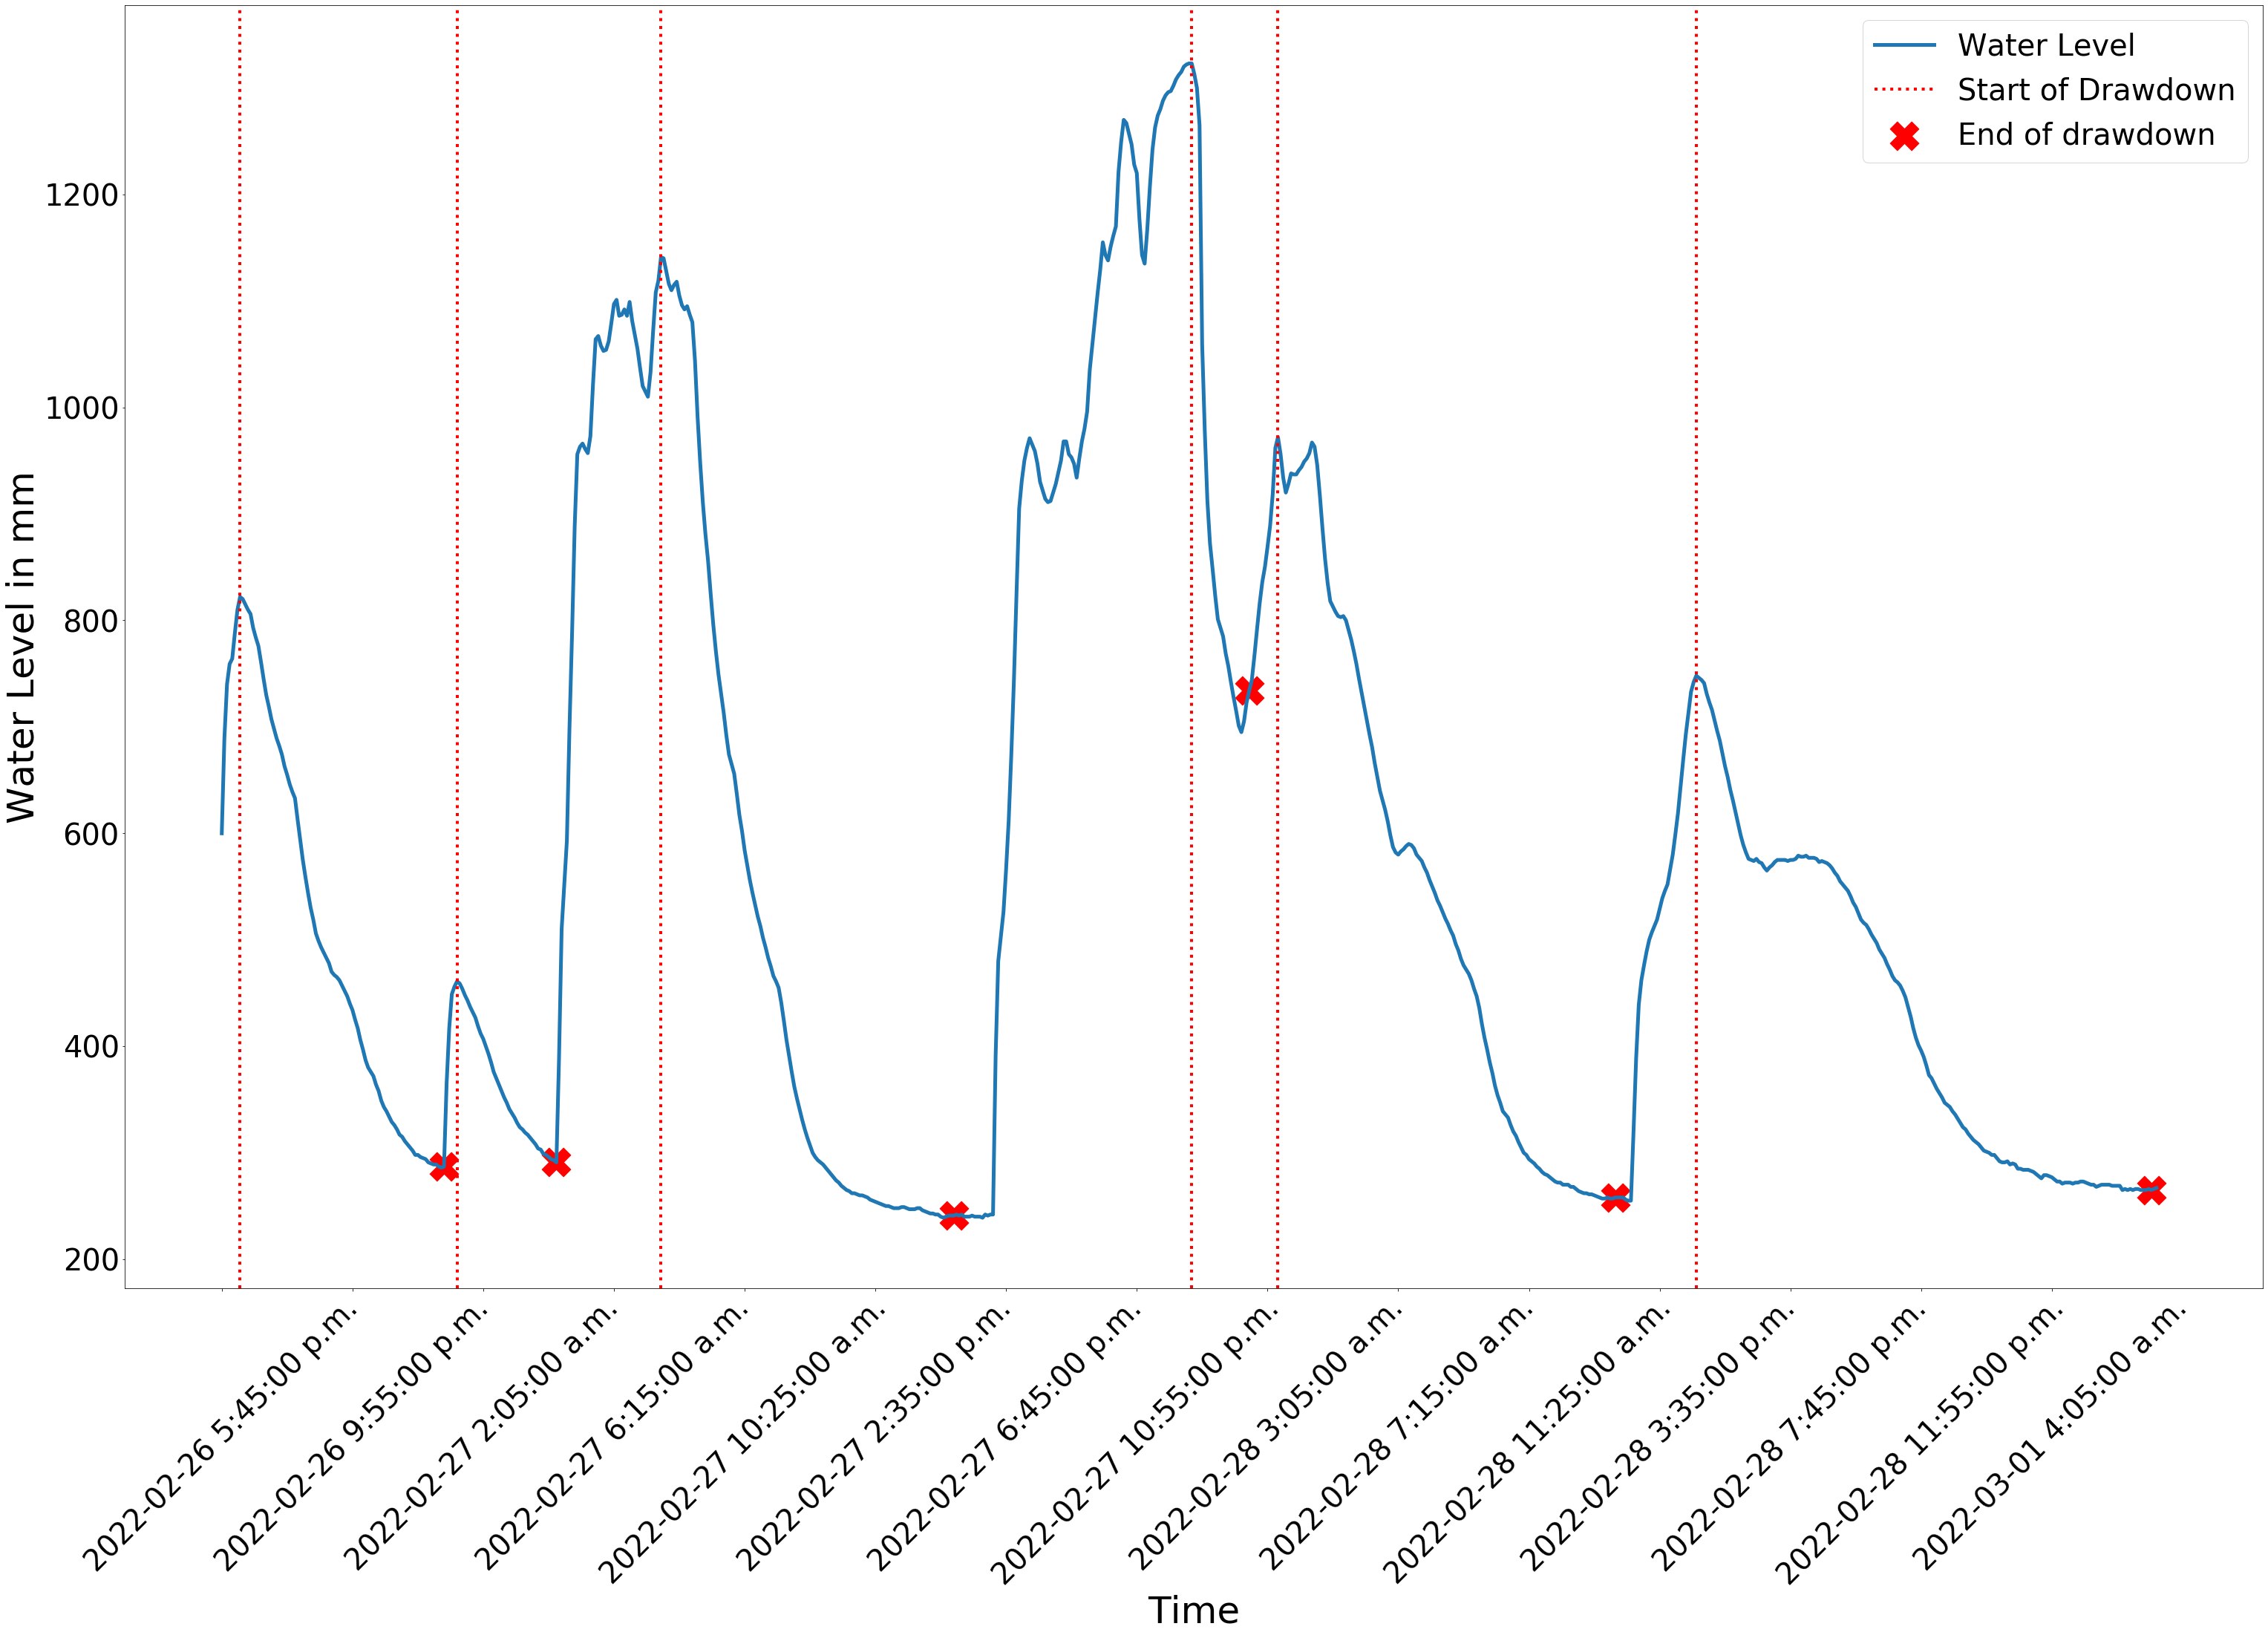

In [40]:
index=2
wfd,e_dd,e_dl,e_dr,start,end=drawdown_wellflood_event(dataset,water_level,index,start_index,end_index)
fig=plt.figure(figsize=(50, 30))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,rf_duration[index],50)])
ax.set_xticklabels([dataset["Timestamp"][i] for i in range(start_index[index],end_index[index],50)])
wle,=plt.plot(wl,label="Water Level",linewidth=5)
for i in start:
    st=plt.axvline(x=i, linewidth=4,color='r',linestyle="dotted",label="Start of Drawdown")
    #st=plt.scatter(i,wl[i],marker="o",s=1500,color="red",label="Start of drawdown")
for i in end:
    en=plt.scatter(i,wl[i],s=1500,marker="X", color='red',label="End of drawdown")
    #st=plt.axvline(x=i, linewidth=2.5,color='r',linestyle="dashdot",label="Start of an event")
#plt.axvline(x=0,linewidth=5,color='r',label="Start of an event")
#plt.axvline(x=np.size(wl)-1,linewidth=5, color='orange',label="End of an event")    
#plt.plot(abs(np.diff(wl)))
#plt.plot(mstd)
#plt.axhline(y=14.2)
plt.xlabel('Time',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=40,rotation=45)
plt.tick_params(axis='y',labelsize=40)
plt.legend(loc = 'best',handles=[wle,st,en],fontsize=40)
#plt.title("Drawdown start and end",fontsize=50)
plt.show()